In [1]:
import pandas as pd
import polars as pl
import plotnine as pn
import numpy as np
from tqdm.notebook import tqdm

import lightgbm as lgb
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.impute import SimpleImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, KNNImputer
from sklearn.pipeline import FeatureUnion, make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import (
    LabelEncoder,
    StandardScaler,
    OneHotEncoder,
    FunctionTransformer,
)
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, root_mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import config_context
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate
import os
import holidays

%load_ext blackcellmagic

### Data Preparation

Focus on CH spot price first

In [2]:
df = pd.read_csv(
    "../../00 Data Retrieval and Cleaning/0_df_final_ml_predictive.csv",
    parse_dates=["date"],
)
df.head()

,date,auction_price_ch_de,auction_price_de_ch,dst,day_ahead_price_at,day_ahead_price_ch,day_ahead_price_de,day_ahead_price_fr,day_ahead_price_it,actual_load_at,...,wind_offshore_actual_aggregated_it,wind_offshore_forecast_de,wind_onshore_actual_aggregated_at,wind_onshore_actual_aggregated_de,wind_onshore_actual_aggregated_fr,wind_onshore_actual_aggregated_it,wind_onshore_ch,wind_onshore_forecast_at,wind_onshore_forecast_de,wind_onshore_forecast_fr
0,2023-01-01 00:00:00+00:00,0.01,6.09,1,NaN,-7.25,-1.07,NaN,NaN,NaN,...,NaN,3390.25,NaN,NaN,NaN,NaN,NaN,1174.0,35415.50,13933.0
1,2023-01-01 01:00:00+00:00,0.01,5.50,1,NaN,-3.99,-1.47,NaN,NaN,NaN,...,NaN,3395.50,NaN,NaN,NaN,NaN,NaN,1194.0,35146.75,13583.0
2,2023-01-01 02:00:00+00:00,0.01,6.45,1,NaN,-7.71,-5.08,NaN,NaN,NaN,...,NaN,3410.25,NaN,NaN,NaN,NaN,NaN,1085.0,34449.00,13230.0
3,2023-01-01 03:00:00+00:00,0.01,9.08,1,NaN,-9.71,-4.49,NaN,NaN,NaN,...,NaN,3431.25,NaN,NaN,NaN,NaN,NaN,897.0,33905.25,12877.0
4,2023-01-01 04:00:00+00:00,0.01,13.33,1,NaN,-15.15,-5.40,NaN,NaN,NaN,...,NaN,3454.25,NaN,NaN,NaN,NaN,NaN,697.0,33362.75,12311.0


Need to lag the other three target variables by 24 hours, haven't done that yet:

In [3]:
df = (
    df
    .assign(
        day_ahead_price_de=lambda x: x["day_ahead_price_de"].shift(24),
        auction_price_de_ch=lambda x: x["auction_price_de_ch"].shift(24),
        auction_price_ch_de=lambda x: x["auction_price_ch_de"].shift(24),
    )
)

In [4]:
df = df.drop(
    columns=df.isna().mean().reset_index(name="missing").query("missing > 0.2")["index"]
)

### Include target lags

- latest available price (last price of previous day)
- last two week prices at exact hour (14 additional cols)

In [5]:
# Adding last available price from previous day
df = df.assign(
    day=lambda x: x.date.dt.date,
    day_ahead_price_ch_last=lambda x: x.groupby("day")["day_ahead_price_ch"].transform("last").shift(24),
)

In [6]:
# Adding lags in 24h steps for the last two weeks
lags = np.arange(24, 49).tolist() + (np.arange(3, 15) * 24).tolist()
print(lags)
for i in lags:
    df[f"day_ahead_price_ch_lag_{i}"] = df["day_ahead_price_ch"].shift(i)

[24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 72, 96, 120, 144, 168, 192, 216, 240, 264, 288, 312, 336]


In [7]:
df.filter(regex="day_ahead_price_ch").info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9501 entries, 0 to 9500
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   day_ahead_price_ch          9501 non-null   float64
 1   day_ahead_price_ch_last     9477 non-null   float64
 2   day_ahead_price_ch_lag_24   9477 non-null   float64
 3   day_ahead_price_ch_lag_25   9476 non-null   float64
 4   day_ahead_price_ch_lag_26   9475 non-null   float64
 5   day_ahead_price_ch_lag_27   9474 non-null   float64
 6   day_ahead_price_ch_lag_28   9473 non-null   float64
 7   day_ahead_price_ch_lag_29   9472 non-null   float64
 8   day_ahead_price_ch_lag_30   9471 non-null   float64
 9   day_ahead_price_ch_lag_31   9470 non-null   float64
 10  day_ahead_price_ch_lag_32   9469 non-null   float64
 11  day_ahead_price_ch_lag_33   9468 non-null   float64
 12  day_ahead_price_ch_lag_34   9467 non-null   float64
 13  day_ahead_price_ch_lag_35   9466 

### Additional Feature Generation

- There might be a benefit of encoding cyclical calendar information
- Additionally: Holidays

Include a trend column:

In [8]:
df = df.assign(trend=lambda x: x.index)

In [9]:
# Define the country (Switzerland)
country = "CH"

regional_holidays = holidays.CH(
    years=df.date.dt.year.unique().tolist()
)

In [10]:
holiday_df = pd.DataFrame(
    {
        "holiday_name": list(regional_holidays.values()),
        "holiday_date": list(regional_holidays.keys()),
    }
)

holiday_df.sort_values("holiday_date").head()

,holiday_name,holiday_date
4,Neujahrestag,2023-01-01
5,Auffahrt,2023-05-18
6,Nationalfeiertag,2023-08-01
7,Weihnachten,2023-12-25
0,Neujahrestag,2024-01-01


In [11]:
holiday_df.value_counts("holiday_name")

holiday_name
Auffahrt            2
Nationalfeiertag    2
Neujahrestag        2
Weihnachten         2
Name: count, dtype: int64

In [12]:
df = (
    df.assign(
        hour=lambda x: x.date.dt.hour + 1,
        month=lambda x: x.date.dt.month,
        quarter=lambda x: x.date.dt.quarter,
        wday=lambda x: x.date.dt.day_of_week + 1,
        weekend=lambda x: np.where(
            x.date.dt.day_name().isin(["Sunday", "Saturday"]), 1, 0
        ),
        work_hour=lambda x: np.where(
            x["hour"].isin(np.arange(17, 24).tolist() + np.arange(1, 5).tolist()), 0, 1
        ),
        week_hour=lambda x: x.date.dt.dayofweek * 24 + (x.date.dt.hour + 1),
        year=lambda x: x.date.dt.year,
        hour_counter=lambda x: np.arange(0, x.shape[0]),
    )
    .assign(day=lambda x: x.date.dt.date)
    .merge(holiday_df, how="left", left_on="day", right_on="holiday_date")
    .drop(["holiday_date", "day"], axis=1)
    .assign(
        holiday_name=lambda x: np.where(
            x["holiday_name"].isna(), "none", x["holiday_name"]
        )
    )
)

In [13]:
df.value_counts("holiday_name")

holiday_name
none                9381
Neujahrestag          48
Auffahrt              24
Nationalfeiertag      24
Weihnachten           24
Name: count, dtype: int64

### Feature Engineering

Other:
- `date`: drop, can't feed into net

Numerical:
- everything but `holiday_name`

Categorical
- `holiday_name`: one-hot encode

#### Cyclical Encoding

- avoid issue with exploding feature space when one-hot encoding hundreds of levels in categorical vars
- puts end of cycle closer to beginning (End of Year is not that different from BOY)

In [14]:
def sin_transformer(period):
    return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))


def cos_transformer(period):
    return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

In [15]:
# hour in day
df["hour_sin"] = sin_transformer(24).fit_transform(df["hour"].astype(float))
df["hour_cos"] = cos_transformer(24).fit_transform(df["hour"].astype(float))

# hour in week
df["week_hour_sin"] = sin_transformer(168).fit_transform(df["week_hour"].astype(float))
df["week_hour_cos"] = cos_transformer(168).fit_transform(df["week_hour"].astype(float))

# month
df["month_sin"] = sin_transformer(12).fit_transform(df["month"].astype(float))
df["month_cos"] = cos_transformer(12).fit_transform(df["month"].astype(float))

# quarter
df["quarter_sin"] = sin_transformer(4).fit_transform(df["quarter"].astype(float))
df["quarter_cos"] = cos_transformer(4).fit_transform(df["quarter"].astype(float))

# weekday
df["wday_sin"] = sin_transformer(7).fit_transform(df["wday"].astype(float))
df["wday_cos"] = cos_transformer(7).fit_transform(df["wday"].astype(float))

df = df.drop(["hour", "month", "quarter", "wday", "week_hour"], axis=1)

#### `sklearn` Pipeline for Data Preparation

In [16]:
manual_cols = ["trend", "unique_id"]
drop_cols = ["date", "day_ahead_price_ch"]

pipeline_cols = [
    col
    for col in df.drop(drop_cols, axis=1).columns
    if col not in manual_cols
]

num_cols = (
    df.drop(drop_cols, axis=1)
    .filter(pipeline_cols)
    .select_dtypes(include=np.number)
    .columns
)
cat_cols = (
    df.drop(drop_cols, axis=1)
    .filter(pipeline_cols)
    .select_dtypes(exclude=np.number)
    .columns
)

In [17]:
pipeline_cols

['auction_price_ch_de',
 'auction_price_de_ch',
 'dst',
 'day_ahead_price_at',
 'day_ahead_price_de',
 'day_ahead_price_fr',
 'day_ahead_price_it',
 'actual_load_at',
 'actual_load_ch',
 'actual_load_de',
 'actual_load_fr',
 'actual_load_it',
 'allocated_capacity_ch_de',
 'allocated_capacity_de_ch',
 'biomass_actual_aggregated_at',
 'biomass_actual_aggregated_de',
 'biomass_actual_aggregated_fr',
 'biomass_actual_aggregated_it',
 'capacity_forecast_at_ch',
 'capacity_forecast_ch_at',
 'capacity_forecast_ch_de_lu',
 'capacity_forecast_ch_fr',
 'capacity_forecast_ch_it',
 'capacity_forecast_de_lu_ch',
 'capacity_forecast_fr_ch',
 'capacity_forecast_it_ch',
 'crossborder_actual_flow_at_ch',
 'crossborder_actual_flow_ch_at',
 'crossborder_actual_flow_ch_de_lu',
 'crossborder_actual_flow_ch_fr',
 'crossborder_actual_flow_ch_it',
 'crossborder_actual_flow_de_lu_ch',
 'crossborder_actual_flow_fr_ch',
 'crossborder_actual_flow_it_ch',
 'fossil_brown_coal_lignite_actual_aggregated_de',
 'fossil

In [18]:
num_cols

Index(['auction_price_ch_de', 'auction_price_de_ch', 'dst',
       'day_ahead_price_at', 'day_ahead_price_de', 'day_ahead_price_fr',
       'day_ahead_price_it', 'actual_load_at', 'actual_load_ch',
       'actual_load_de',
       ...
       'hour_sin', 'hour_cos', 'week_hour_sin', 'week_hour_cos', 'month_sin',
       'month_cos', 'quarter_sin', 'quarter_cos', 'wday_sin', 'wday_cos'],
      dtype='object', length=152)

In [19]:
cat_cols

Index(['holiday_name'], dtype='object')

In [20]:
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer()),
        # ("scaler", StandardScaler())
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        (
            "encoder",
            OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        ),
    ]
)

# Making column transformer where all transformers in the pipelines are included
preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", numeric_transformer, num_cols),
        ("categorical", categorical_transformer, cat_cols),
    ],
    remainder="passthrough",
)

### Validation set

Do the tuning on a validation set in the second quarter of 2023:

In [21]:
val_start = pd.Timestamp("2023-04-01").tz_localize("UTC")
val_end = pd.Timestamp("2023-06-30").tz_localize("UTC")

val_days = df.query("date >= @val_start & date <= @val_end").date.dt.date.unique()

In [22]:
lookback_days = 30
preds = []

num_boost_rounds = 100

param = dict(verbose=-1, objective="regression", metric="rmse")

for current_day in tqdm(val_days):
    train_start_day = current_day - pd.Timedelta(days=lookback_days)
    train_end_day = current_day - pd.Timedelta(days=1)
    
    df_train = df.query("@train_start_day <= date.dt.date <= @train_end_day")
    df_test = df.query("date.dt.date == @current_day")
    
    # Split data
    X_train = df_train.drop(columns=["date", "day_ahead_price_ch"])
    y_train = df_train["day_ahead_price_ch"]

    X_test = df_test.drop(columns=["date", "day_ahead_price_ch"])
    y_test = df_test["day_ahead_price_ch"]

    # Preprocess data
    fitted_preprocessor = preprocessor.fit(X_train)

    X_train_preprocessed = pd.DataFrame(
        fitted_preprocessor.transform(X_train),
        columns=fitted_preprocessor.get_feature_names_out(),
    )

    X_test_preprocessed = pd.DataFrame(
        fitted_preprocessor.transform(X_test),
        columns=fitted_preprocessor.get_feature_names_out(),
    )

    # Replace prefixes in column names
    new_cols = X_train_preprocessed.columns.str.replace('numeric__', '').str.replace('categorical__', '').str.replace('remainder__', '')

    # Assign new column names to the DataFrame
    X_train_preprocessed.columns = new_cols
    X_test_preprocessed.columns = new_cols

    # Create LightGBM dataset
    train_data = lgb.Dataset(X_train_preprocessed, label=y_train, free_raw_data=False)

    # Train the model
    bst = lgb.train(
        params=param,
        train_set=train_data,
        valid_sets=[train_data],
        num_boost_round=num_boost_rounds,
        # callbacks=[lgb.early_stopping(stopping_rounds=10)],
    )

    # Make predictions on validation set
    y_pred = bst.predict(X_test_preprocessed, num_iteration=bst.best_iteration)

    preds.extend(y_pred.tolist())

  0%|          | 0/91 [00:00<?, ?it/s]

In [23]:
preds = pd.DataFrame({
    "date": df.query("date.dt.date in @val_days")["date"].to_list(),
    "preds": preds,
    "actual": df.query("date.dt.date in @val_days")["day_ahead_price_ch"].to_list()
})

<Axes: xlabel='date'>

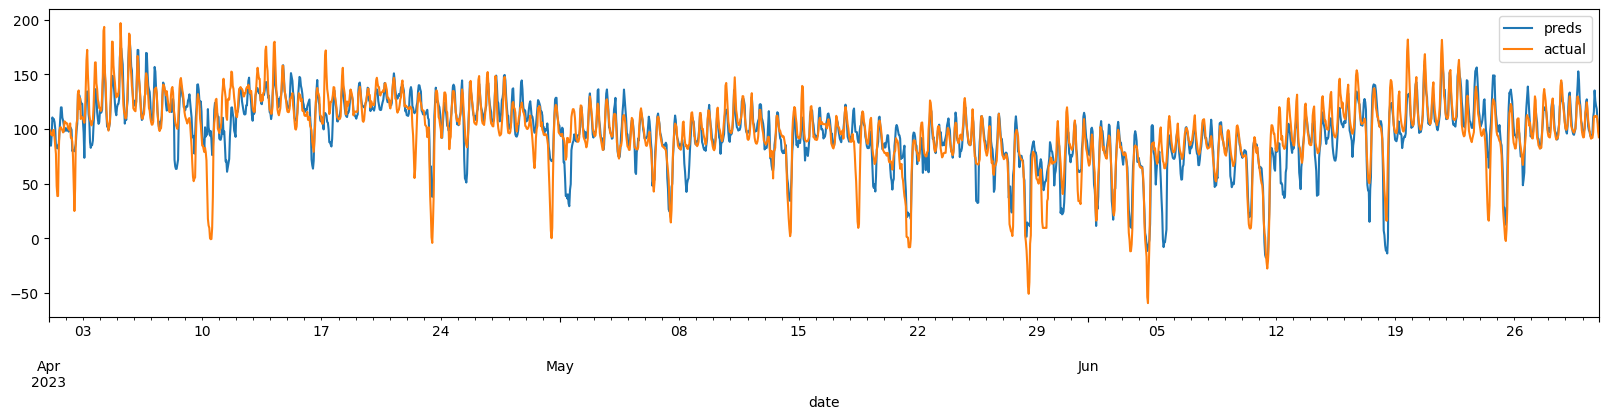

In [24]:
preds.plot(x="date", y=["preds", "actual"], figsize=(20, 4))

In [25]:
baseline = (
    df.assign(baseline=lambda x: x.day_ahead_price_ch.shift(24))
    .query("date.dt.date in @val_days")
    .filter(["date", "day_ahead_price_ch", "baseline"])
    .rename(columns={"baseline": "preds", "day_ahead_price_ch": "actual"})
)

In [26]:
print("Metric for LGBM Model")
print("R2 Score: ", r2_score(preds["actual"], preds["preds"]))
print("MAE: ", mean_absolute_error(preds["actual"], preds["preds"]))
print("MAPE: ", mean_absolute_percentage_error(preds["actual"], preds["preds"]))
print("RMSE: ", root_mean_squared_error(preds["actual"], preds["preds"]))

Metric for LGBM Model
R2 Score:  0.7176369563486089
MAE:  11.608556752242079
MAPE:  5.141287102482159
RMSE:  17.125518726769382


In [27]:
print("Metric for baseline model")
print("R2 Score: ", r2_score(baseline["actual"], baseline["preds"]))
print("MAE: ", mean_absolute_error(baseline["actual"], baseline["preds"]))
print("MAPE: ", mean_absolute_percentage_error(baseline["actual"], baseline["preds"]))
print("RMSE: ", root_mean_squared_error(baseline["actual"], baseline["preds"]))

Metric for baseline model
R2 Score:  0.42190934749479436
MAE:  15.763873626373627
MAPE:  3.6357653190834913
RMSE:  24.504044993883582


### Hyperparameter Optimization

In [28]:
val_start = pd.Timestamp("2023-02-01").tz_localize("UTC")
val_end = pd.Timestamp("2023-12-30").tz_localize("UTC")

val_days = df.query("date >= @val_start & date <= @val_end").date.dt.date.unique()

In [29]:
def objective(trial):
    
    lookback_days = trial.suggest_int("lookback_days", 1, 30)
    preds = []
    num_boost_rounds = trial.suggest_int("num_boost_rounds", 50, 500)

    # Define the parameter grid
    param = {
        "verbose": -1,
        'objective': 'regression', 
        'metric': 'rmse',
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),
        "max_depth" : trial.suggest_int('max_depth', 3, 15),
        'num_leaves': trial.suggest_int('num_leaves', 10, 120),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'min_split_gain': trial.suggest_float('min_split_gain', 1e-8, 1.0, log=True),
    }

    for current_day in tqdm(val_days):
        train_start_day = current_day - pd.Timedelta(days=lookback_days)
        train_end_day = current_day - pd.Timedelta(days=1)

        df_train = df.query("@train_start_day <= date.dt.date <= @train_end_day")
        df_test = df.query("date.dt.date == @current_day")

        # Split data
        X_train = df_train.drop(columns=["date", "day_ahead_price_ch"])
        y_train = df_train["day_ahead_price_ch"]

        X_test = df_test.drop(columns=["date", "day_ahead_price_ch"])
        y_test = df_test["day_ahead_price_ch"]

        # Preprocess data
        fitted_preprocessor = preprocessor.fit(X_train)

        X_train_preprocessed = pd.DataFrame(
            fitted_preprocessor.transform(X_train),
            columns=fitted_preprocessor.get_feature_names_out(),
        )

        X_test_preprocessed = pd.DataFrame(
            fitted_preprocessor.transform(X_test),
            columns=fitted_preprocessor.get_feature_names_out(),
        )

        # Replace prefixes in column names
        new_cols = (
            X_train_preprocessed.columns.str.replace("numeric__", "")
            .str.replace("categorical__", "")
            .str.replace("remainder__", "")
        )

        # Assign new column names to the DataFrame
        X_train_preprocessed.columns = new_cols
        X_test_preprocessed.columns = new_cols

        # Create LightGBM dataset
        train_data = lgb.Dataset(
            X_train_preprocessed, label=y_train, free_raw_data=False
        )

        # Train the model
        bst = lgb.train(
            params=param,
            train_set=train_data,
            valid_sets=[train_data],
            num_boost_round=num_boost_rounds,
            # callbacks=[lgb.early_stopping(stopping_rounds=10)],
        )

        # Make predictions on validation set
        y_pred = bst.predict(X_test_preprocessed, num_iteration=bst.best_iteration)

        preds.extend(y_pred.tolist())

    preds = pd.DataFrame(
        {
            "date": df.query("date.dt.date in @val_days")["date"].to_list(),
            "preds": preds,
            "actual": df.query("date.dt.date in @val_days")[
                "day_ahead_price_ch"
            ].to_list(),
        }
    )

    return root_mean_squared_error(preds["actual"], preds["preds"])

In [30]:
# Create a study object and specify the direction (minimize)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=None, timeout=60*60*8)

[I 2024-05-20 01:01:42,030] A new study created in memory with name: no-name-11cdbad1-5df1-43bc-b493-b9a690e65fc7


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:03:13,663] Trial 0 finished with value: 31.52829797029997 and parameters: {'lookback_days': 21, 'num_boost_rounds': 328, 'learning_rate': 2.621066309452747e-05, 'max_depth': 7, 'num_leaves': 20, 'lambda_l1': 0.08485741178361889, 'lambda_l2': 0.04371112358594708, 'min_split_gain': 0.023674121246800676}. Best is trial 0 with value: 31.52829797029997.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:04:43,845] Trial 1 finished with value: 17.41408301300425 and parameters: {'lookback_days': 16, 'num_boost_rounds': 423, 'learning_rate': 0.08996083553419332, 'max_depth': 15, 'num_leaves': 75, 'lambda_l1': 7.945766148622554, 'lambda_l2': 1.3216508924799536e-06, 'min_split_gain': 2.43762725537112e-05}. Best is trial 1 with value: 17.41408301300425.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:05:46,454] Trial 2 finished with value: 24.21889166886352 and parameters: {'lookback_days': 5, 'num_boost_rounds': 453, 'learning_rate': 0.0019141716823438855, 'max_depth': 14, 'num_leaves': 18, 'lambda_l1': 1.5733984107793175e-06, 'lambda_l2': 0.0011407606889910235, 'min_split_gain': 0.11881974669803046}. Best is trial 1 with value: 17.41408301300425.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:07:18,728] Trial 3 finished with value: 28.598616756287292 and parameters: {'lookback_days': 30, 'num_boost_rounds': 136, 'learning_rate': 0.001658254352285917, 'max_depth': 9, 'num_leaves': 111, 'lambda_l1': 0.0033865417960850623, 'lambda_l2': 0.0006062630450533308, 'min_split_gain': 7.38260369904351e-05}. Best is trial 1 with value: 17.41408301300425.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:08:25,328] Trial 4 finished with value: 20.375707436935755 and parameters: {'lookback_days': 8, 'num_boost_rounds': 335, 'learning_rate': 0.003988689213188979, 'max_depth': 6, 'num_leaves': 39, 'lambda_l1': 2.7477306240131898e-05, 'lambda_l2': 3.954287235076688e-07, 'min_split_gain': 2.6727426904703578e-08}. Best is trial 1 with value: 17.41408301300425.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:09:25,482] Trial 5 finished with value: 30.0957105496793 and parameters: {'lookback_days': 11, 'num_boost_rounds': 201, 'learning_rate': 1.985645078451372e-05, 'max_depth': 6, 'num_leaves': 35, 'lambda_l1': 0.0017027941367265304, 'lambda_l2': 0.00013514481214386512, 'min_split_gain': 1.4338587333774455e-08}. Best is trial 1 with value: 17.41408301300425.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:10:52,037] Trial 6 finished with value: 30.189749761306423 and parameters: {'lookback_days': 16, 'num_boost_rounds': 407, 'learning_rate': 6.711427233472489e-05, 'max_depth': 4, 'num_leaves': 106, 'lambda_l1': 8.142048017470005e-05, 'lambda_l2': 0.8541256879663841, 'min_split_gain': 0.00017273130866938839}. Best is trial 1 with value: 17.41408301300425.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:13:26,301] Trial 7 finished with value: 31.895736919073993 and parameters: {'lookback_days': 23, 'num_boost_rounds': 458, 'learning_rate': 2.135903818431422e-05, 'max_depth': 7, 'num_leaves': 44, 'lambda_l1': 0.000154545647893261, 'lambda_l2': 0.0015332247567027837, 'min_split_gain': 2.474183796252132e-07}. Best is trial 1 with value: 17.41408301300425.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:14:24,677] Trial 8 finished with value: 33.01246898278587 and parameters: {'lookback_days': 30, 'num_boost_rounds': 91, 'learning_rate': 2.639502665902358e-05, 'max_depth': 6, 'num_leaves': 11, 'lambda_l1': 3.810247422552483, 'lambda_l2': 0.0003626221969993664, 'min_split_gain': 9.81385452105183e-07}. Best is trial 1 with value: 17.41408301300425.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:15:47,112] Trial 9 finished with value: 18.64195491970603 and parameters: {'lookback_days': 12, 'num_boost_rounds': 310, 'learning_rate': 0.07270419268135565, 'max_depth': 13, 'num_leaves': 58, 'lambda_l1': 5.224982073073676e-07, 'lambda_l2': 2.9033123240975187, 'min_split_gain': 1.5658000112800576e-08}. Best is trial 1 with value: 17.41408301300425.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:16:24,012] Trial 10 finished with value: 27.806843148472375 and parameters: {'lookback_days': 1, 'num_boost_rounds': 222, 'learning_rate': 0.08002493626885064, 'max_depth': 12, 'num_leaves': 82, 'lambda_l1': 9.07702778774036, 'lambda_l2': 1.043329743645899e-08, 'min_split_gain': 0.0002154857237199441}. Best is trial 1 with value: 17.41408301300425.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:18:10,889] Trial 11 finished with value: 17.624746572666343 and parameters: {'lookback_days': 15, 'num_boost_rounds': 356, 'learning_rate': 0.09059723487521437, 'max_depth': 15, 'num_leaves': 71, 'lambda_l1': 5.4035833344442267e-08, 'lambda_l2': 8.211756115467285, 'min_split_gain': 3.777838753764038e-06}. Best is trial 1 with value: 17.41408301300425.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:20:11,316] Trial 12 finished with value: 17.71403736906321 and parameters: {'lookback_days': 18, 'num_boost_rounds': 380, 'learning_rate': 0.01021552666488729, 'max_depth': 15, 'num_leaves': 81, 'lambda_l1': 1.4544208051344498e-08, 'lambda_l2': 8.050853029322096e-07, 'min_split_gain': 8.466322952368871e-06}. Best is trial 1 with value: 17.41408301300425.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:23:05,291] Trial 13 finished with value: 16.599077184606713 and parameters: {'lookback_days': 23, 'num_boost_rounds': 499, 'learning_rate': 0.017257533039198237, 'max_depth': 11, 'num_leaves': 79, 'lambda_l1': 1.0087426227061786e-08, 'lambda_l2': 6.199016548559517e-06, 'min_split_gain': 0.0023674667475389963}. Best is trial 13 with value: 16.599077184606713.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:26:13,741] Trial 14 finished with value: 16.395859245291042 and parameters: {'lookback_days': 25, 'num_boost_rounds': 498, 'learning_rate': 0.014566414167142352, 'max_depth': 11, 'num_leaves': 93, 'lambda_l1': 0.10710916799912981, 'lambda_l2': 6.171324330581325e-06, 'min_split_gain': 0.0031633928147694486}. Best is trial 14 with value: 16.395859245291042.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:29:22,252] Trial 15 finished with value: 16.421239669042038 and parameters: {'lookback_days': 25, 'num_boost_rounds': 486, 'learning_rate': 0.013663798094954402, 'max_depth': 11, 'num_leaves': 96, 'lambda_l1': 0.09942434992113008, 'lambda_l2': 2.682130820823977e-05, 'min_split_gain': 0.002648480560349991}. Best is trial 14 with value: 16.395859245291042.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:32:52,192] Trial 16 finished with value: 30.1157242715797 and parameters: {'lookback_days': 26, 'num_boost_rounds': 498, 'learning_rate': 0.0002790322910763793, 'max_depth': 10, 'num_leaves': 99, 'lambda_l1': 0.05696420739515789, 'lambda_l2': 2.2317482523422592e-05, 'min_split_gain': 0.9399962077318949}. Best is trial 14 with value: 16.395859245291042.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:34:52,293] Trial 17 finished with value: 16.645541444065145 and parameters: {'lookback_days': 26, 'num_boost_rounds': 255, 'learning_rate': 0.01380677454111451, 'max_depth': 9, 'num_leaves': 94, 'lambda_l1': 0.17522549439779855, 'lambda_l2': 1.5510616174854837e-08, 'min_split_gain': 0.002580710528937192}. Best is trial 14 with value: 16.395859245291042.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:38:01,381] Trial 18 finished with value: 17.140573027759746 and parameters: {'lookback_days': 26, 'num_boost_rounds': 434, 'learning_rate': 0.005656000685639941, 'max_depth': 11, 'num_leaves': 119, 'lambda_l1': 0.007946877225396724, 'lambda_l2': 0.00794435565206291, 'min_split_gain': 0.0027297530628372798}. Best is trial 14 with value: 16.395859245291042.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:40:17,657] Trial 19 finished with value: 29.54972677180274 and parameters: {'lookback_days': 21, 'num_boost_rounds': 385, 'learning_rate': 0.0003012792321970615, 'max_depth': 13, 'num_leaves': 91, 'lambda_l1': 0.5406136728295501, 'lambda_l2': 2.0243385617495457e-05, 'min_split_gain': 0.020857873658597786}. Best is trial 14 with value: 16.395859245291042.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:43:18,054] Trial 20 finished with value: 16.330582981607684 and parameters: {'lookback_days': 28, 'num_boost_rounds': 500, 'learning_rate': 0.032300129305445936, 'max_depth': 9, 'num_leaves': 120, 'lambda_l1': 0.012827440783732292, 'lambda_l2': 8.829303553036943e-08, 'min_split_gain': 0.0007325041494416012}. Best is trial 20 with value: 16.330582981607684.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:46:16,434] Trial 21 finished with value: 16.38051253386307 and parameters: {'lookback_days': 28, 'num_boost_rounds': 498, 'learning_rate': 0.029128690848308807, 'max_depth': 9, 'num_leaves': 119, 'lambda_l1': 0.013943965710424666, 'lambda_l2': 6.476621171250655e-08, 'min_split_gain': 0.0008272405979264649}. Best is trial 20 with value: 16.330582981607684.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:49:09,343] Trial 22 finished with value: 16.376864645128137 and parameters: {'lookback_days': 29, 'num_boost_rounds': 464, 'learning_rate': 0.031338222573700086, 'max_depth': 9, 'num_leaves': 120, 'lambda_l1': 0.015698767436028313, 'lambda_l2': 6.712936519685093e-08, 'min_split_gain': 0.0005970127242932482}. Best is trial 20 with value: 16.330582981607684.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:51:47,944] Trial 23 finished with value: 16.308837990166648 and parameters: {'lookback_days': 29, 'num_boost_rounds': 453, 'learning_rate': 0.03299605358434488, 'max_depth': 8, 'num_leaves': 120, 'lambda_l1': 0.011156981643222423, 'lambda_l2': 1.0148342573301604e-07, 'min_split_gain': 0.0004258201829193564}. Best is trial 23 with value: 16.308837990166648.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:54:29,023] Trial 24 finished with value: 16.36240076906222 and parameters: {'lookback_days': 30, 'num_boost_rounds': 454, 'learning_rate': 0.03317098958337836, 'max_depth': 8, 'num_leaves': 107, 'lambda_l1': 0.0007580546096587156, 'lambda_l2': 1.1925527532146945e-07, 'min_split_gain': 0.0004223752022680788}. Best is trial 23 with value: 16.308837990166648.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:56:52,841] Trial 25 finished with value: 16.333729349455318 and parameters: {'lookback_days': 28, 'num_boost_rounds': 409, 'learning_rate': 0.03278904556187726, 'max_depth': 8, 'num_leaves': 107, 'lambda_l1': 0.0011210854121507974, 'lambda_l2': 9.07195617084359e-08, 'min_split_gain': 5.740788196295703e-05}. Best is trial 23 with value: 16.308837990166648.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 01:58:26,912] Trial 26 finished with value: 18.334206072932066 and parameters: {'lookback_days': 20, 'num_boost_rounds': 399, 'learning_rate': 0.005011902344535441, 'max_depth': 4, 'num_leaves': 111, 'lambda_l1': 1.4934096812905963e-05, 'lambda_l2': 3.303219807747849e-07, 'min_split_gain': 4.1160989986001283e-05}. Best is trial 23 with value: 16.308837990166648.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:00:50,246] Trial 27 finished with value: 29.21639413333146 and parameters: {'lookback_days': 28, 'num_boost_rounds': 302, 'learning_rate': 0.0006140914543801861, 'max_depth': 8, 'num_leaves': 103, 'lambda_l1': 0.0007189445644685029, 'lambda_l2': 2.4645162839679106e-06, 'min_split_gain': 1.285131466960243e-05}. Best is trial 23 with value: 16.308837990166648.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:02:03,555] Trial 28 finished with value: 15.433083229090492 and parameters: {'lookback_days': 23, 'num_boost_rounds': 355, 'learning_rate': 0.047805156875673084, 'max_depth': 3, 'num_leaves': 63, 'lambda_l1': 1.0992858503880194, 'lambda_l2': 2.5999834475434152e-08, 'min_split_gain': 0.015787698809128392}. Best is trial 28 with value: 15.433083229090492.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:03:17,726] Trial 29 finished with value: 15.566862309741632 and parameters: {'lookback_days': 22, 'num_boost_rounds': 373, 'learning_rate': 0.05320775547300198, 'max_depth': 3, 'num_leaves': 63, 'lambda_l1': 0.5985261607860813, 'lambda_l2': 2.1647959196308237e-08, 'min_split_gain': 0.026763874927640242}. Best is trial 28 with value: 15.433083229090492.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:04:31,364] Trial 30 finished with value: 15.41135923760896 and parameters: {'lookback_days': 23, 'num_boost_rounds': 352, 'learning_rate': 0.051684207490919426, 'max_depth': 3, 'num_leaves': 58, 'lambda_l1': 1.8914569481967367, 'lambda_l2': 2.0298280165042885e-08, 'min_split_gain': 0.023582632724470226}. Best is trial 30 with value: 15.41135923760896.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:05:44,898] Trial 31 finished with value: 15.40910706561946 and parameters: {'lookback_days': 23, 'num_boost_rounds': 358, 'learning_rate': 0.05087569981255155, 'max_depth': 3, 'num_leaves': 59, 'lambda_l1': 1.0641403395365376, 'lambda_l2': 1.98548159083833e-08, 'min_split_gain': 0.02882782043215303}. Best is trial 31 with value: 15.40910706561946.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:06:55,032] Trial 32 finished with value: 16.69960676415017 and parameters: {'lookback_days': 19, 'num_boost_rounds': 356, 'learning_rate': 0.05633215697274246, 'max_depth': 3, 'num_leaves': 55, 'lambda_l1': 1.44511249364574, 'lambda_l2': 1.8476286201078175e-08, 'min_split_gain': 0.02901418373085211}. Best is trial 31 with value: 15.40910706561946.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:08:02,256] Trial 33 finished with value: 15.445970834162868 and parameters: {'lookback_days': 23, 'num_boost_rounds': 291, 'learning_rate': 0.05881591970955394, 'max_depth': 3, 'num_leaves': 58, 'lambda_l1': 0.9297507501734726, 'lambda_l2': 2.3582547981233166e-08, 'min_split_gain': 0.16960986324957872}. Best is trial 31 with value: 15.40910706561946.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:09:14,161] Trial 34 finished with value: 19.220947940152794 and parameters: {'lookback_days': 18, 'num_boost_rounds': 267, 'learning_rate': 0.006162070546765857, 'max_depth': 4, 'num_leaves': 51, 'lambda_l1': 1.4901315379349604, 'lambda_l2': 5.097113324086322e-07, 'min_split_gain': 0.23074463454344218}. Best is trial 31 with value: 15.40910706561946.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:10:52,020] Trial 35 finished with value: 22.30707424054187 and parameters: {'lookback_days': 23, 'num_boost_rounds': 300, 'learning_rate': 0.002552387639439278, 'max_depth': 5, 'num_leaves': 68, 'lambda_l1': 0.49291938549446784, 'lambda_l2': 0.13399009629547654, 'min_split_gain': 0.09604085135213807}. Best is trial 31 with value: 15.40910706561946.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:12:04,899] Trial 36 finished with value: 16.881808511971997 and parameters: {'lookback_days': 21, 'num_boost_rounds': 344, 'learning_rate': 0.008345904082276149, 'max_depth': 3, 'num_leaves': 47, 'lambda_l1': 3.2427066980297257, 'lambda_l2': 1.6124172515068357e-06, 'min_split_gain': 0.918744216882948}. Best is trial 31 with value: 15.40910706561946.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:13:09,570] Trial 37 finished with value: 17.611775491189263 and parameters: {'lookback_days': 15, 'num_boost_rounds': 239, 'learning_rate': 0.09913669735880087, 'max_depth': 5, 'num_leaves': 32, 'lambda_l1': 9.804788935793184, 'lambda_l2': 3.062285417705987e-08, 'min_split_gain': 0.10445081595250941}. Best is trial 31 with value: 15.40910706561946.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:14:14,870] Trial 38 finished with value: 16.430065400848566 and parameters: {'lookback_days': 24, 'num_boost_rounds': 179, 'learning_rate': 0.018978731396276705, 'max_depth': 4, 'num_leaves': 60, 'lambda_l1': 0.21512780908598747, 'lambda_l2': 2.226420108809585e-07, 'min_split_gain': 0.009009907274939919}. Best is trial 31 with value: 15.40910706561946.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:15:30,178] Trial 39 finished with value: 17.36226603186556 and parameters: {'lookback_days': 17, 'num_boost_rounds': 287, 'learning_rate': 0.05352956314702123, 'max_depth': 5, 'num_leaves': 25, 'lambda_l1': 1.7595648221254483, 'lambda_l2': 4.024092130033564e-08, 'min_split_gain': 0.009830845570019025}. Best is trial 31 with value: 15.40910706561946.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:16:38,723] Trial 40 finished with value: 26.665333491556986 and parameters: {'lookback_days': 20, 'num_boost_rounds': 320, 'learning_rate': 0.0011062352101360248, 'max_depth': 3, 'num_leaves': 73, 'lambda_l1': 0.39974783650093, 'lambda_l2': 2.134429099606883e-07, 'min_split_gain': 0.2678858402821155}. Best is trial 31 with value: 15.40910706561946.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:17:52,288] Trial 41 finished with value: 15.557158160703427 and parameters: {'lookback_days': 22, 'num_boost_rounds': 367, 'learning_rate': 0.051990177163700246, 'max_depth': 3, 'num_leaves': 62, 'lambda_l1': 0.037143559201857954, 'lambda_l2': 1.7278793394059754e-08, 'min_split_gain': 0.037955784385767175}. Best is trial 31 with value: 15.40910706561946.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:19:10,958] Trial 42 finished with value: 15.890464352904216 and parameters: {'lookback_days': 22, 'num_boost_rounds': 335, 'learning_rate': 0.05148972247397766, 'max_depth': 4, 'num_leaves': 65, 'lambda_l1': 0.039347601445091036, 'lambda_l2': 1.2049768046085214e-08, 'min_split_gain': 0.06130580890489418}. Best is trial 31 with value: 15.40910706561946.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:20:25,261] Trial 43 finished with value: 15.553519839112665 and parameters: {'lookback_days': 24, 'num_boost_rounds': 354, 'learning_rate': 0.023918640978698696, 'max_depth': 3, 'num_leaves': 54, 'lambda_l1': 3.8640614675683187, 'lambda_l2': 1.0874243992403827e-08, 'min_split_gain': 0.30066665003272075}. Best is trial 31 with value: 15.40910706561946.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:21:59,055] Trial 44 finished with value: 16.18389524291895 and parameters: {'lookback_days': 24, 'num_boost_rounds': 323, 'learning_rate': 0.01971152593421489, 'max_depth': 5, 'num_leaves': 42, 'lambda_l1': 3.5004925663517183, 'lambda_l2': 4.070729967790112e-08, 'min_split_gain': 0.35433458009983076}. Best is trial 31 with value: 15.40910706561946.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:23:26,529] Trial 45 finished with value: 30.1854279369551 and parameters: {'lookback_days': 14, 'num_boost_rounds': 345, 'learning_rate': 1.1984300570042206e-05, 'max_depth': 6, 'num_leaves': 51, 'lambda_l1': 1.1239377575054854, 'lambda_l2': 5.896297216279138e-07, 'min_split_gain': 0.013634823514985862}. Best is trial 31 with value: 15.40910706561946.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:24:23,101] Trial 46 finished with value: 20.60000967653703 and parameters: {'lookback_days': 6, 'num_boost_rounds': 285, 'learning_rate': 0.02276036844378642, 'max_depth': 4, 'num_leaves': 55, 'lambda_l1': 4.934012656379523, 'lambda_l2': 2.0029176037760814e-07, 'min_split_gain': 0.2901233971516604}. Best is trial 31 with value: 15.40910706561946.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:25:43,567] Trial 47 finished with value: 16.266749322049183 and parameters: {'lookback_days': 24, 'num_boost_rounds': 391, 'learning_rate': 0.009195546861455281, 'max_depth': 3, 'num_leaves': 86, 'lambda_l1': 0.2780439878258793, 'lambda_l2': 1.1567113772032218e-06, 'min_split_gain': 0.05801670802608297}. Best is trial 31 with value: 15.40910706561946.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:27:18,908] Trial 48 finished with value: 19.523306803128904 and parameters: {'lookback_days': 20, 'num_boost_rounds': 427, 'learning_rate': 0.003397461261537608, 'max_depth': 4, 'num_leaves': 37, 'lambda_l1': 9.817764019964194, 'lambda_l2': 1.0594325331361688e-08, 'min_split_gain': 0.007115906276208009}. Best is trial 31 with value: 15.40910706561946.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:28:17,461] Trial 49 finished with value: 18.25345179313998 and parameters: {'lookback_days': 10, 'num_boost_rounds': 196, 'learning_rate': 0.07372805927854001, 'max_depth': 6, 'num_leaves': 70, 'lambda_l1': 0.003716535981185234, 'lambda_l2': 0.00011556233949590492, 'min_split_gain': 7.719270779045104e-08}. Best is trial 31 with value: 15.40910706561946.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:29:09,827] Trial 50 finished with value: 16.58812639324674 and parameters: {'lookback_days': 26, 'num_boost_rounds': 65, 'learning_rate': 0.04850814564410979, 'max_depth': 5, 'num_leaves': 49, 'lambda_l1': 0.9179005877547282, 'lambda_l2': 2.905859690395065e-06, 'min_split_gain': 0.14584421005416656}. Best is trial 31 with value: 15.40910706561946.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:30:21,548] Trial 51 finished with value: 15.515300289555176 and parameters: {'lookback_days': 22, 'num_boost_rounds': 348, 'learning_rate': 0.07563101124516683, 'max_depth': 3, 'num_leaves': 60, 'lambda_l1': 0.04252085081255527, 'lambda_l2': 3.2120619382112604e-08, 'min_split_gain': 0.04742641143739949}. Best is trial 31 with value: 15.40910706561946.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:31:35,935] Trial 52 finished with value: 15.40014162962452 and parameters: {'lookback_days': 25, 'num_boost_rounds': 361, 'learning_rate': 0.09963879877025689, 'max_depth': 3, 'num_leaves': 76, 'lambda_l1': 2.730904216347258, 'lambda_l2': 3.652817919308937e-08, 'min_split_gain': 0.7983784217630173}. Best is trial 52 with value: 15.40014162962452.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:32:46,789] Trial 53 finished with value: 15.297192007030864 and parameters: {'lookback_days': 25, 'num_boost_rounds': 320, 'learning_rate': 0.07785247165250406, 'max_depth': 3, 'num_leaves': 60, 'lambda_l1': 0.17133662343764713, 'lambda_l2': 3.698571069902968e-08, 'min_split_gain': 0.5633838389156498}. Best is trial 53 with value: 15.297192007030864.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:34:10,171] Trial 54 finished with value: 15.612432273875797 and parameters: {'lookback_days': 27, 'num_boost_rounds': 327, 'learning_rate': 0.09163453319487284, 'max_depth': 4, 'num_leaves': 77, 'lambda_l1': 0.13835558223026062, 'lambda_l2': 4.162432598990543e-08, 'min_split_gain': 0.4273546413259493}. Best is trial 53 with value: 15.297192007030864.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:35:21,300] Trial 55 finished with value: 15.478652351955134 and parameters: {'lookback_days': 25, 'num_boost_rounds': 312, 'learning_rate': 0.04327347806512305, 'max_depth': 3, 'num_leaves': 66, 'lambda_l1': 2.6444856476837026, 'lambda_l2': 0.0033496103052309033, 'min_split_gain': 0.6989378898752103}. Best is trial 53 with value: 15.297192007030864.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:36:44,395] Trial 56 finished with value: 15.996545035415965 and parameters: {'lookback_days': 27, 'num_boost_rounds': 263, 'learning_rate': 0.0685816463696529, 'max_depth': 5, 'num_leaves': 75, 'lambda_l1': 0.7047205466698416, 'lambda_l2': 1.1085416298369805e-07, 'min_split_gain': 0.08262773756467014}. Best is trial 53 with value: 15.297192007030864.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:38:19,350] Trial 57 finished with value: 32.08487928427473 and parameters: {'lookback_days': 25, 'num_boost_rounds': 368, 'learning_rate': 7.58739026704533e-05, 'max_depth': 4, 'num_leaves': 84, 'lambda_l1': 0.2567213810408272, 'lambda_l2': 3.174753870397514e-07, 'min_split_gain': 0.15232177063404098}. Best is trial 53 with value: 15.297192007030864.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:40:00,395] Trial 58 finished with value: 16.819570702780766 and parameters: {'lookback_days': 23, 'num_boost_rounds': 284, 'learning_rate': 0.011433874718912856, 'max_depth': 6, 'num_leaves': 57, 'lambda_l1': 0.09691815670077178, 'lambda_l2': 5.297889654749222e-08, 'min_split_gain': 0.5982067909650494}. Best is trial 53 with value: 15.297192007030864.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:42:12,577] Trial 59 finished with value: 16.208389827715266 and parameters: {'lookback_days': 27, 'num_boost_rounds': 407, 'learning_rate': 0.04023001896965106, 'max_depth': 7, 'num_leaves': 44, 'lambda_l1': 2.240642650186952, 'lambda_l2': 0.043636503208163605, 'min_split_gain': 0.006526456738124024}. Best is trial 53 with value: 15.297192007030864.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:43:18,238] Trial 60 finished with value: 15.682546171986782 and parameters: {'lookback_days': 21, 'num_boost_rounds': 300, 'learning_rate': 0.06855785588644896, 'max_depth': 3, 'num_leaves': 71, 'lambda_l1': 1.1472199266481886e-06, 'lambda_l2': 1.5174042097560272e-07, 'min_split_gain': 0.0013524616647655817}. Best is trial 53 with value: 15.297192007030864.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:44:21,629] Trial 61 finished with value: 15.49126273829282 and parameters: {'lookback_days': 25, 'num_boost_rounds': 241, 'learning_rate': 0.09760782021647232, 'max_depth': 3, 'num_leaves': 66, 'lambda_l1': 4.968608695091883, 'lambda_l2': 0.0007529254040198553, 'min_split_gain': 0.9053567989378144}. Best is trial 53 with value: 15.297192007030864.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:45:43,426] Trial 62 finished with value: 15.845879993974968 and parameters: {'lookback_days': 25, 'num_boost_rounds': 311, 'learning_rate': 0.040788244274236274, 'max_depth': 4, 'num_leaves': 67, 'lambda_l1': 2.0601480902677474, 'lambda_l2': 0.006038080302739283, 'min_split_gain': 0.18984505450293887}. Best is trial 53 with value: 15.297192007030864.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:46:59,555] Trial 63 finished with value: 15.546433211971111 and parameters: {'lookback_days': 23, 'num_boost_rounds': 381, 'learning_rate': 0.025039746389793945, 'max_depth': 3, 'num_leaves': 63, 'lambda_l1': 0.8706055463213087, 'lambda_l2': 0.002451072800657996, 'min_split_gain': 0.5590534314879986}. Best is trial 53 with value: 15.297192007030864.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:48:22,660] Trial 64 finished with value: 15.671871983918836 and parameters: {'lookback_days': 26, 'num_boost_rounds': 334, 'learning_rate': 0.04031475049503165, 'max_depth': 4, 'num_leaves': 80, 'lambda_l1': 1.593684877913099e-05, 'lambda_l2': 0.020947796899855466, 'min_split_gain': 0.019627643995182652}. Best is trial 53 with value: 15.297192007030864.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:49:29,273] Trial 65 finished with value: 17.10641163697735 and parameters: {'lookback_days': 19, 'num_boost_rounds': 310, 'learning_rate': 0.016518114253180425, 'max_depth': 3, 'num_leaves': 60, 'lambda_l1': 0.45741941602680253, 'lambda_l2': 0.16903925782267423, 'min_split_gain': 0.12849777777451893}. Best is trial 53 with value: 15.297192007030864.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:50:50,889] Trial 66 finished with value: 15.265705805312061 and parameters: {'lookback_days': 29, 'num_boost_rounds': 366, 'learning_rate': 0.06660054447739189, 'max_depth': 3, 'num_leaves': 73, 'lambda_l1': 2.1514389718949447, 'lambda_l2': 0.00013962988276808858, 'min_split_gain': 0.4922554813160993}. Best is trial 66 with value: 15.265705805312061.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:52:36,023] Trial 67 finished with value: 15.884420038708033 and parameters: {'lookback_days': 29, 'num_boost_rounds': 440, 'learning_rate': 0.06462594346401103, 'max_depth': 5, 'num_leaves': 88, 'lambda_l1': 5.80154567595531, 'lambda_l2': 1.1314108944465537e-05, 'min_split_gain': 0.438301049353363}. Best is trial 66 with value: 15.265705805312061.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:53:27,952] Trial 68 finished with value: 23.382997018328545 and parameters: {'lookback_days': 2, 'num_boost_rounds': 419, 'learning_rate': 0.027320831121351623, 'max_depth': 4, 'num_leaves': 78, 'lambda_l1': 0.0723382257982507, 'lambda_l2': 0.00017631135954990457, 'min_split_gain': 1.9771930697630603e-06}. Best is trial 66 with value: 15.265705805312061.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:54:47,683] Trial 69 finished with value: 15.1996345890437 and parameters: {'lookback_days': 30, 'num_boost_rounds': 364, 'learning_rate': 0.08304680573144023, 'max_depth': 3, 'num_leaves': 73, 'lambda_l1': 1.1675811436213348, 'lambda_l2': 2.9175634723825386e-08, 'min_split_gain': 0.00011462807821619525}. Best is trial 69 with value: 15.1996345890437.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:56:26,516] Trial 70 finished with value: 15.610110148260695 and parameters: {'lookback_days': 30, 'num_boost_rounds': 395, 'learning_rate': 0.08285950290243606, 'max_depth': 4, 'num_leaves': 71, 'lambda_l1': 0.3279630500079832, 'lambda_l2': 5.6369265322636015e-05, 'min_split_gain': 9.739690192573947e-05}. Best is trial 69 with value: 15.1996345890437.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:57:45,220] Trial 71 finished with value: 15.265386872491943 and parameters: {'lookback_days': 29, 'num_boost_rounds': 364, 'learning_rate': 0.03748935785410576, 'max_depth': 3, 'num_leaves': 75, 'lambda_l1': 1.171794261397972, 'lambda_l2': 2.4654893863645825e-08, 'min_split_gain': 0.07600862689738867}. Best is trial 69 with value: 15.1996345890437.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 02:59:05,669] Trial 72 finished with value: 15.206236567671562 and parameters: {'lookback_days': 30, 'num_boost_rounds': 364, 'learning_rate': 0.09830710969818214, 'max_depth': 3, 'num_leaves': 82, 'lambda_l1': 1.567391262542905, 'lambda_l2': 8.069738063740884e-08, 'min_split_gain': 0.03666900383672514}. Best is trial 69 with value: 15.1996345890437.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:00:24,413] Trial 73 finished with value: 15.342872123454095 and parameters: {'lookback_days': 29, 'num_boost_rounds': 366, 'learning_rate': 0.03589547070925675, 'max_depth': 3, 'num_leaves': 74, 'lambda_l1': 9.935177929827425e-05, 'lambda_l2': 5.593292582507098e-08, 'min_split_gain': 0.0001960415715303097}. Best is trial 69 with value: 15.1996345890437.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:01:58,566] Trial 74 finished with value: 15.640059724789626 and parameters: {'lookback_days': 30, 'num_boost_rounds': 371, 'learning_rate': 0.037899955682674236, 'max_depth': 4, 'num_leaves': 75, 'lambda_l1': 0.00014065547125502911, 'lambda_l2': 7.433869319359821e-08, 'min_split_gain': 0.0001652032832437636}. Best is trial 69 with value: 15.1996345890437.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:04:56,340] Trial 75 finished with value: 16.586319624279056 and parameters: {'lookback_days': 29, 'num_boost_rounds': 384, 'learning_rate': 0.09792608299350018, 'max_depth': 14, 'num_leaves': 82, 'lambda_l1': 0.00025108468329915825, 'lambda_l2': 5.912385975660505e-08, 'min_split_gain': 5.144225156479077e-07}. Best is trial 69 with value: 15.1996345890437.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:06:16,265] Trial 76 finished with value: 15.170369630264204 and parameters: {'lookback_days': 28, 'num_boost_rounds': 366, 'learning_rate': 0.0611840750465734, 'max_depth': 3, 'num_leaves': 87, 'lambda_l1': 2.0485820144761203e-07, 'lambda_l2': 4.186423483469188e-07, 'min_split_gain': 2.9463627602023366e-05}. Best is trial 76 with value: 15.170369630264204.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:07:33,281] Trial 77 finished with value: 15.21256109580102 and parameters: {'lookback_days': 28, 'num_boost_rounds': 366, 'learning_rate': 0.07114422354072292, 'max_depth': 3, 'num_leaves': 89, 'lambda_l1': 3.140651806604915e-07, 'lambda_l2': 3.6465283323145205e-07, 'min_split_gain': 0.00020020782043213842}. Best is trial 76 with value: 15.170369630264204.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:09:08,341] Trial 78 finished with value: 15.637069791841311 and parameters: {'lookback_days': 28, 'num_boost_rounds': 411, 'learning_rate': 0.03256696801172635, 'max_depth': 4, 'num_leaves': 90, 'lambda_l1': 1.5481559771021907e-07, 'lambda_l2': 8.178058541781537e-07, 'min_split_gain': 2.8864520877773266e-05}. Best is trial 76 with value: 15.170369630264204.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:11:46,030] Trial 79 finished with value: 16.485877612863334 and parameters: {'lookback_days': 29, 'num_boost_rounds': 396, 'learning_rate': 0.07376079541001505, 'max_depth': 10, 'num_leaves': 85, 'lambda_l1': 4.886711798507495e-06, 'lambda_l2': 2.7190953986587693e-06, 'min_split_gain': 0.00023760085010259796}. Best is trial 76 with value: 15.170369630264204.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:13:01,868] Trial 80 finished with value: 15.295720350295017 and parameters: {'lookback_days': 30, 'num_boost_rounds': 338, 'learning_rate': 0.06230892889308014, 'max_depth': 3, 'num_leaves': 101, 'lambda_l1': 3.4016900599966374e-08, 'lambda_l2': 3.3059346861443964e-07, 'min_split_gain': 2.1399837658035844e-05}. Best is trial 76 with value: 15.170369630264204.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:14:17,527] Trial 81 finished with value: 15.158217069359056 and parameters: {'lookback_days': 30, 'num_boost_rounds': 338, 'learning_rate': 0.06437087090107249, 'max_depth': 3, 'num_leaves': 97, 'lambda_l1': 2.614849414364448e-08, 'lambda_l2': 2.8723573425186737e-07, 'min_split_gain': 1.3249288639173651e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:15:33,867] Trial 82 finished with value: 15.19731769893374 and parameters: {'lookback_days': 30, 'num_boost_rounds': 335, 'learning_rate': 0.06327130537760632, 'max_depth': 3, 'num_leaves': 98, 'lambda_l1': 3.942037578715562e-08, 'lambda_l2': 2.718587124621573e-07, 'min_split_gain': 1.1912869115531177e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:16:50,509] Trial 83 finished with value: 15.211601190727102 and parameters: {'lookback_days': 30, 'num_boost_rounds': 337, 'learning_rate': 0.06476817595309617, 'max_depth': 3, 'num_leaves': 93, 'lambda_l1': 2.7696340176635408e-08, 'lambda_l2': 3.831340084468271e-07, 'min_split_gain': 1.016193306345036e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:18:22,835] Trial 84 finished with value: 15.617757949289468 and parameters: {'lookback_days': 30, 'num_boost_rounds': 375, 'learning_rate': 0.06152535766247757, 'max_depth': 4, 'num_leaves': 94, 'lambda_l1': 9.454545025747588e-08, 'lambda_l2': 5.18904223256987e-06, 'min_split_gain': 7.004982194292351e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:19:38,243] Trial 85 finished with value: 15.438400042856342 and parameters: {'lookback_days': 28, 'num_boost_rounds': 340, 'learning_rate': 0.022260149816321222, 'max_depth': 3, 'num_leaves': 98, 'lambda_l1': 2.449087784001492e-08, 'lambda_l2': 1.346320596007763e-06, 'min_split_gain': 5.159140414435024e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:21:23,512] Trial 86 finished with value: 32.13698429146692 and parameters: {'lookback_days': 27, 'num_boost_rounds': 385, 'learning_rate': 0.00010152431948418408, 'max_depth': 4, 'num_leaves': 92, 'lambda_l1': 2.594839913077725e-07, 'lambda_l2': 3.962887148375941e-07, 'min_split_gain': 1.2517344061631301e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:22:51,326] Trial 87 finished with value: 29.929307659721406 and parameters: {'lookback_days': 30, 'num_boost_rounds': 404, 'learning_rate': 0.00043088893328905914, 'max_depth': 3, 'num_leaves': 104, 'lambda_l1': 1.3397698292246527e-08, 'lambda_l2': 6.665343968438635e-07, 'min_split_gain': 2.992312155994762e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:24:06,647] Trial 88 finished with value: 15.433089491632389 and parameters: {'lookback_days': 29, 'num_boost_rounds': 330, 'learning_rate': 0.028387931955721906, 'max_depth': 3, 'num_leaves': 97, 'lambda_l1': 7.809429833118197e-08, 'lambda_l2': 1.5925822827866303e-07, 'min_split_gain': 6.171000205765917e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:25:06,547] Trial 89 finished with value: 15.873980063697779 and parameters: {'lookback_days': 28, 'num_boost_rounds': 136, 'learning_rate': 0.04432402056661763, 'max_depth': 4, 'num_leaves': 90, 'lambda_l1': 3.963324779436378e-07, 'lambda_l2': 1.1516286519793922e-06, 'min_split_gain': 1.929727969409078e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:26:46,270] Trial 90 finished with value: 15.952440494255846 and parameters: {'lookback_days': 28, 'num_boost_rounds': 354, 'learning_rate': 0.05720901469985751, 'max_depth': 5, 'num_leaves': 87, 'lambda_l1': 2.652443334877661e-08, 'lambda_l2': 2.0871747259032124e-07, 'min_split_gain': 4.831109716260924e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:28:02,357] Trial 91 finished with value: 15.178077119854056 and parameters: {'lookback_days': 30, 'num_boost_rounds': 341, 'learning_rate': 0.06610638122180174, 'max_depth': 3, 'num_leaves': 100, 'lambda_l1': 3.530891238666157e-08, 'lambda_l2': 2.5505801876111185e-07, 'min_split_gain': 2.440749737423535e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:29:18,458] Trial 92 finished with value: 15.20767593213234 and parameters: {'lookback_days': 30, 'num_boost_rounds': 347, 'learning_rate': 0.08033320977317772, 'max_depth': 3, 'num_leaves': 112, 'lambda_l1': 5.135548444431799e-08, 'lambda_l2': 9.57660685751831e-08, 'min_split_gain': 1.1115702564141446e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:30:35,279] Trial 93 finished with value: 15.191640788238907 and parameters: {'lookback_days': 30, 'num_boost_rounds': 339, 'learning_rate': 0.04772217100872029, 'max_depth': 3, 'num_leaves': 113, 'lambda_l1': 7.390953820397404e-08, 'lambda_l2': 9.042219025319672e-08, 'min_split_gain': 3.3409060531480725e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:31:53,721] Trial 94 finished with value: 15.264007938979589 and parameters: {'lookback_days': 30, 'num_boost_rounds': 349, 'learning_rate': 0.08167866649413488, 'max_depth': 3, 'num_leaves': 114, 'lambda_l1': 4.634705331796896e-08, 'lambda_l2': 1.2942838020678739e-07, 'min_split_gain': 1.1842512777895403e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:33:18,923] Trial 95 finished with value: 15.552266236075619 and parameters: {'lookback_days': 30, 'num_boost_rounds': 321, 'learning_rate': 0.04828681400431725, 'max_depth': 4, 'num_leaves': 111, 'lambda_l1': 1.1891506877896918e-07, 'lambda_l2': 4.811081949598117e-07, 'min_split_gain': 2.3530478906021816e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:34:31,767] Trial 96 finished with value: 15.313905299526965 and parameters: {'lookback_days': 27, 'num_boost_rounds': 331, 'learning_rate': 0.0765396130863437, 'max_depth': 3, 'num_leaves': 117, 'lambda_l1': 2.0453412378258265e-07, 'lambda_l2': 2.598139684257241e-07, 'min_split_gain': 3.1053456170190816e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:37:03,496] Trial 97 finished with value: 25.707085276981807 and parameters: {'lookback_days': 28, 'num_boost_rounds': 300, 'learning_rate': 0.0013897228781527672, 'max_depth': 12, 'num_leaves': 109, 'lambda_l1': 6.60029430335195e-08, 'lambda_l2': 9.526051529642696e-08, 'min_split_gain': 0.00010305501640832296}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:38:31,040] Trial 98 finished with value: 15.582491561915703 and parameters: {'lookback_days': 30, 'num_boost_rounds': 342, 'learning_rate': 0.05572135779093177, 'max_depth': 4, 'num_leaves': 95, 'lambda_l1': 1.0489432079918647e-06, 'lambda_l2': 8.161676710770697e-07, 'min_split_gain': 8.18651696110197e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:39:50,035] Trial 99 finished with value: 15.343866720182016 and parameters: {'lookback_days': 29, 'num_boost_rounds': 377, 'learning_rate': 0.09806833337301861, 'max_depth': 3, 'num_leaves': 106, 'lambda_l1': 1.7104593420696472e-08, 'lambda_l2': 1.8070774083695766e-06, 'min_split_gain': 1.121311529551119e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:41:07,097] Trial 100 finished with value: 15.222484515614777 and parameters: {'lookback_days': 27, 'num_boost_rounds': 358, 'learning_rate': 0.08187095289904832, 'max_depth': 3, 'num_leaves': 101, 'lambda_l1': 6.079194143112078e-07, 'lambda_l2': 1.369320729315056e-07, 'min_split_gain': 5.456828000140596e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:42:22,772] Trial 101 finished with value: 15.226888383123388 and parameters: {'lookback_days': 27, 'num_boost_rounds': 349, 'learning_rate': 0.08145268828566052, 'max_depth': 3, 'num_leaves': 99, 'lambda_l1': 4.6682158377036685e-07, 'lambda_l2': 1.2040799463405226e-07, 'min_split_gain': 1.7064587588444065e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:43:41,370] Trial 102 finished with value: 15.193994938940744 and parameters: {'lookback_days': 30, 'num_boost_rounds': 359, 'learning_rate': 0.0463691477710486, 'max_depth': 3, 'num_leaves': 102, 'lambda_l1': 5.3589504032394966e-08, 'lambda_l2': 4.1418435817869214e-07, 'min_split_gain': 6.561470575306734e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:45:06,001] Trial 103 finished with value: 15.631476292276108 and parameters: {'lookback_days': 30, 'num_boost_rounds': 316, 'learning_rate': 0.04945792953993692, 'max_depth': 4, 'num_leaves': 104, 'lambda_l1': 4.6275922836924455e-08, 'lambda_l2': 4.7095143970501506e-07, 'min_split_gain': 4.070729029416955e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:46:23,353] Trial 104 finished with value: 15.41167896307342 and parameters: {'lookback_days': 29, 'num_boost_rounds': 339, 'learning_rate': 0.030256456609724938, 'max_depth': 3, 'num_leaves': 113, 'lambda_l1': 1.1812144765577001e-08, 'lambda_l2': 2.8298574307929063e-07, 'min_split_gain': 4.023717155732412e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:47:45,340] Trial 105 finished with value: 15.217334104957578 and parameters: {'lookback_days': 30, 'num_boost_rounds': 385, 'learning_rate': 0.06427197007626288, 'max_depth': 3, 'num_leaves': 83, 'lambda_l1': 2.3235828183893594e-08, 'lambda_l2': 8.517729322888972e-08, 'min_split_gain': 1.1467952769447877e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:49:09,326] Trial 106 finished with value: 15.636130335891792 and parameters: {'lookback_days': 28, 'num_boost_rounds': 330, 'learning_rate': 0.04477696189798591, 'max_depth': 4, 'num_leaves': 102, 'lambda_l1': 1.2229130189054005e-07, 'lambda_l2': 9.852811631438314e-07, 'min_split_gain': 8.586412340388908e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:50:27,232] Trial 107 finished with value: 15.361723106958344 and parameters: {'lookback_days': 26, 'num_boost_rounds': 374, 'learning_rate': 0.05830120427147439, 'max_depth': 3, 'num_leaves': 89, 'lambda_l1': 2.873571129462412e-07, 'lambda_l2': 4.395416867919164e-06, 'min_split_gain': 3.6758057772689596e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:52:03,117] Trial 108 finished with value: 15.82598250044717 and parameters: {'lookback_days': 29, 'num_boost_rounds': 361, 'learning_rate': 0.020016623634626002, 'max_depth': 4, 'num_leaves': 93, 'lambda_l1': 4.0889505187737384e-08, 'lambda_l2': 1.7343846308316488e-07, 'min_split_gain': 1.300059244752663e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:53:13,548] Trial 109 finished with value: 15.30077867431977 and parameters: {'lookback_days': 28, 'num_boost_rounds': 293, 'learning_rate': 0.035910496403656754, 'max_depth': 3, 'num_leaves': 109, 'lambda_l1': 6.388526560020368e-08, 'lambda_l2': 9.854678221663097e-06, 'min_split_gain': 7.712380632976598e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:54:25,537] Trial 110 finished with value: 32.13448731769681 and parameters: {'lookback_days': 30, 'num_boost_rounds': 274, 'learning_rate': 0.00017402785218995553, 'max_depth': 3, 'num_leaves': 114, 'lambda_l1': 1.017142732609695e-08, 'lambda_l2': 5.688532376032259e-07, 'min_split_gain': 1.7088899335795172e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:55:48,595] Trial 111 finished with value: 15.165204926111336 and parameters: {'lookback_days': 30, 'num_boost_rounds': 391, 'learning_rate': 0.06582062699464362, 'max_depth': 3, 'num_leaves': 83, 'lambda_l1': 1.7369061504939965e-08, 'lambda_l2': 8.597933101188776e-08, 'min_split_gain': 1.1542989604793216e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:57:14,388] Trial 112 finished with value: 15.274467258952892 and parameters: {'lookback_days': 29, 'num_boost_rounds': 418, 'learning_rate': 0.06938168625846723, 'max_depth': 3, 'num_leaves': 80, 'lambda_l1': 1.9462569983711353e-08, 'lambda_l2': 3.5740455872084455e-07, 'min_split_gain': 0.0003180408896526382}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 03:58:31,293] Trial 113 finished with value: 15.297038884873055 and parameters: {'lookback_days': 30, 'num_boost_rounds': 349, 'learning_rate': 0.044876017701826, 'max_depth': 3, 'num_leaves': 96, 'lambda_l1': 3.21376780744742e-08, 'lambda_l2': 7.014268218259823e-08, 'min_split_gain': 2.6443794743967204e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:00:05,999] Trial 114 finished with value: 15.600383586004625 and parameters: {'lookback_days': 29, 'num_boost_rounds': 397, 'learning_rate': 0.08609495206930697, 'max_depth': 4, 'num_leaves': 99, 'lambda_l1': 1.478442932067181e-07, 'lambda_l2': 2.478202353510894e-07, 'min_split_gain': 6.310155991760659e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:01:27,008] Trial 115 finished with value: 15.168284854428366 and parameters: {'lookback_days': 28, 'num_boost_rounds': 388, 'learning_rate': 0.05896244227536273, 'max_depth': 3, 'num_leaves': 92, 'lambda_l1': 9.42600892388195e-08, 'lambda_l2': 2.0024893557330358e-06, 'min_split_gain': 5.243482321377563e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:02:53,734] Trial 116 finished with value: 15.244162436899513 and parameters: {'lookback_days': 29, 'num_boost_rounds': 440, 'learning_rate': 0.05537410355366396, 'max_depth': 3, 'num_leaves': 92, 'lambda_l1': 6.114897271421302e-08, 'lambda_l2': 8.52605772122291e-08, 'min_split_gain': 3.636445937167452e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:04:17,073] Trial 117 finished with value: 15.734954415515634 and parameters: {'lookback_days': 30, 'num_boost_rounds': 307, 'learning_rate': 0.09982867201673189, 'max_depth': 4, 'num_leaves': 108, 'lambda_l1': 8.480091389650136e-08, 'lambda_l2': 5.164299218135577e-08, 'min_split_gain': 5.385189959673903e-07}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:05:41,021] Trial 118 finished with value: 15.393601648095071 and parameters: {'lookback_days': 30, 'num_boost_rounds': 389, 'learning_rate': 0.02545281475351975, 'max_depth': 3, 'num_leaves': 106, 'lambda_l1': 1.922975694771592e-07, 'lambda_l2': 1.96250113923927e-07, 'min_split_gain': 9.983215104117943e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:06:49,519] Trial 119 finished with value: 18.474520107376545 and parameters: {'lookback_days': 12, 'num_boost_rounds': 324, 'learning_rate': 0.035362019084749674, 'max_depth': 4, 'num_leaves': 86, 'lambda_l1': 1.8454870443222242e-08, 'lambda_l2': 2.098673515319654e-06, 'min_split_gain': 1.681306472536579e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:08:08,523] Trial 120 finished with value: 15.203749533430978 and parameters: {'lookback_days': 28, 'num_boost_rounds': 374, 'learning_rate': 0.042943918715371475, 'max_depth': 3, 'num_leaves': 95, 'lambda_l1': 3.5976804893890017e-06, 'lambda_l2': 1.7025718535103068e-08, 'min_split_gain': 5.003196438918612e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:09:30,211] Trial 121 finished with value: 32.624074150517615 and parameters: {'lookback_days': 28, 'num_boost_rounds': 375, 'learning_rate': 3.653363636310065e-05, 'max_depth': 3, 'num_leaves': 95, 'lambda_l1': 3.708727410888233e-08, 'lambda_l2': 2.444795236273881e-08, 'min_split_gain': 5.597575678242876e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:10:49,158] Trial 122 finished with value: 15.319161797173349 and parameters: {'lookback_days': 29, 'num_boost_rounds': 357, 'learning_rate': 0.06261189956334141, 'max_depth': 3, 'num_leaves': 100, 'lambda_l1': 2.7959117527236845e-05, 'lambda_l2': 1.7067890044136884e-08, 'min_split_gain': 1.8686825346585266e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:12:09,521] Trial 123 finished with value: 15.26183683640324 and parameters: {'lookback_days': 27, 'num_boost_rounds': 381, 'learning_rate': 0.04267402331778775, 'max_depth': 3, 'num_leaves': 97, 'lambda_l1': 2.8290068607222915e-06, 'lambda_l2': 3.292380918976697e-08, 'min_split_gain': 7.81263285804387e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:13:32,083] Trial 124 finished with value: 15.180103308531995 and parameters: {'lookback_days': 28, 'num_boost_rounds': 410, 'learning_rate': 0.05257530146111268, 'max_depth': 3, 'num_leaves': 117, 'lambda_l1': 1.1245763764708882e-07, 'lambda_l2': 4.3544153430144594e-08, 'min_split_gain': 2.997529318608507e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:15:05,882] Trial 125 finished with value: 15.652657551865069 and parameters: {'lookback_days': 26, 'num_boost_rounds': 411, 'learning_rate': 0.05067412307751038, 'max_depth': 4, 'num_leaves': 117, 'lambda_l1': 9.571803668863776e-08, 'lambda_l2': 4.9827492349681874e-08, 'min_split_gain': 4.288943003384203e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:16:29,370] Trial 126 finished with value: 15.397222449653169 and parameters: {'lookback_days': 29, 'num_boost_rounds': 391, 'learning_rate': 0.030208047619879153, 'max_depth': 3, 'num_leaves': 117, 'lambda_l1': 6.682602895763883e-07, 'lambda_l2': 1.371065733937019e-08, 'min_split_gain': 6.275109369819317e-07}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:17:50,651] Trial 127 finished with value: 15.62852936908024 and parameters: {'lookback_days': 28, 'num_boost_rounds': 371, 'learning_rate': 0.01526166930594241, 'max_depth': 3, 'num_leaves': 113, 'lambda_l1': 5.5124406469827525e-08, 'lambda_l2': 1.0075594304252057e-08, 'min_split_gain': 2.88909030375272e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:19:26,059] Trial 128 finished with value: 15.669054549509799 and parameters: {'lookback_days': 28, 'num_boost_rounds': 418, 'learning_rate': 0.08288004212039266, 'max_depth': 4, 'num_leaves': 105, 'lambda_l1': 2.0094397530933462e-07, 'lambda_l2': 1.1754204739866492e-07, 'min_split_gain': 1.4972150323500312e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:20:30,763] Trial 129 finished with value: 18.16933433789415 and parameters: {'lookback_days': 8, 'num_boost_rounds': 398, 'learning_rate': 0.03837627605954285, 'max_depth': 3, 'num_leaves': 12, 'lambda_l1': 1.4249412406220408e-08, 'lambda_l2': 2.748803973303458e-08, 'min_split_gain': 2.1768144554032554e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:21:52,827] Trial 130 finished with value: 15.225153572448223 and parameters: {'lookback_days': 27, 'num_boost_rounds': 401, 'learning_rate': 0.0526770984103863, 'max_depth': 3, 'num_leaves': 84, 'lambda_l1': 9.361045628938329e-08, 'lambda_l2': 7.577180419799779e-08, 'min_split_gain': 0.0001262902748921759}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:23:19,149] Trial 131 finished with value: 15.20527402281141 and parameters: {'lookback_days': 30, 'num_boost_rounds': 430, 'learning_rate': 0.06733951621618071, 'max_depth': 3, 'num_leaves': 91, 'lambda_l1': 3.091333248061383e-08, 'lambda_l2': 6.526314196266017e-07, 'min_split_gain': 1.2122558318335463e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:24:44,630] Trial 132 finished with value: 15.250553001595312 and parameters: {'lookback_days': 29, 'num_boost_rounds': 436, 'learning_rate': 0.07220489000784108, 'max_depth': 3, 'num_leaves': 91, 'lambda_l1': 3.832274432159252e-08, 'lambda_l2': 1.8431711727980698e-07, 'min_split_gain': 1.5703629395443155e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:26:16,120] Trial 133 finished with value: 15.22290844599944 and parameters: {'lookback_days': 30, 'num_boost_rounds': 465, 'learning_rate': 0.08715900436360619, 'max_depth': 3, 'num_leaves': 79, 'lambda_l1': 1.9043518675305e-08, 'lambda_l2': 6.892102947107103e-07, 'min_split_gain': 6.250192890807488e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:27:56,970] Trial 134 finished with value: 15.603729921357168 and parameters: {'lookback_days': 30, 'num_boost_rounds': 424, 'learning_rate': 0.0596613097122128, 'max_depth': 4, 'num_leaves': 111, 'lambda_l1': 1.2989959757549868e-07, 'lambda_l2': 3.752844110346319e-08, 'min_split_gain': 2.8404979453043425e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:29:21,889] Trial 135 finished with value: 15.279028798018775 and parameters: {'lookback_days': 29, 'num_boost_rounds': 431, 'learning_rate': 0.045930355927460934, 'max_depth': 3, 'num_leaves': 87, 'lambda_l1': 4.777783626847656e-08, 'lambda_l2': 1.2390152735898908e-07, 'min_split_gain': 1.2250193273688338e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:31:50,310] Trial 136 finished with value: 16.420546444764987 and parameters: {'lookback_days': 30, 'num_boost_rounds': 347, 'learning_rate': 0.07216715677105698, 'max_depth': 10, 'num_leaves': 103, 'lambda_l1': 2.7423911716565884e-08, 'lambda_l2': 5.191915297682871e-08, 'min_split_gain': 2.5291328364162216e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:34:46,463] Trial 137 finished with value: 27.37128116568656 and parameters: {'lookback_days': 28, 'num_boost_rounds': 408, 'learning_rate': 0.0007314925296794925, 'max_depth': 7, 'num_leaves': 81, 'lambda_l1': 5.451908629571895e-08, 'lambda_l2': 1.677033040035029e-08, 'min_split_gain': 6.194959776768735e-08}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:36:06,305] Trial 138 finished with value: 15.302561949166988 and parameters: {'lookback_days': 29, 'num_boost_rounds': 363, 'learning_rate': 0.03953089348118175, 'max_depth': 3, 'num_leaves': 97, 'lambda_l1': 0.0025218292693545397, 'lambda_l2': 2.625520860222284e-07, 'min_split_gain': 4.117451014375433e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:37:37,013] Trial 139 finished with value: 15.628321246610524 and parameters: {'lookback_days': 27, 'num_boost_rounds': 380, 'learning_rate': 0.05849406471213706, 'max_depth': 4, 'num_leaves': 88, 'lambda_l1': 1.0188181944862682e-08, 'lambda_l2': 1.4984265024895695e-06, 'min_split_gain': 8.776422563574078e-07}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:38:54,244] Trial 140 finished with value: 15.23024623738358 and parameters: {'lookback_days': 30, 'num_boost_rounds': 355, 'learning_rate': 0.09848537804010411, 'max_depth': 3, 'num_leaves': 94, 'lambda_l1': 7.69314493484774e-08, 'lambda_l2': 5.847847499321717e-07, 'min_split_gain': 2.965899966016327e-07}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:40:10,823] Trial 141 finished with value: 15.280278198784028 and parameters: {'lookback_days': 30, 'num_boost_rounds': 342, 'learning_rate': 0.07316075170165799, 'max_depth': 3, 'num_leaves': 92, 'lambda_l1': 2.7245457590985422e-08, 'lambda_l2': 3.634317403418773e-07, 'min_split_gain': 9.24809211481627e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:41:39,966] Trial 142 finished with value: 15.333832905328313 and parameters: {'lookback_days': 29, 'num_boost_rounds': 447, 'learning_rate': 0.0632698455343906, 'max_depth': 3, 'num_leaves': 101, 'lambda_l1': 3.039685113519452e-08, 'lambda_l2': 9.075200942818053e-07, 'min_split_gain': 3.8455648819573585e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:42:55,815] Trial 143 finished with value: 15.28500767194056 and parameters: {'lookback_days': 30, 'num_boost_rounds': 332, 'learning_rate': 0.05337701278238668, 'max_depth': 3, 'num_leaves': 95, 'lambda_l1': 1.6599987832287317e-08, 'lambda_l2': 1.56111341209935e-07, 'min_split_gain': 9.722795590341936e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:44:11,477] Trial 144 finished with value: 15.278449885568333 and parameters: {'lookback_days': 28, 'num_boost_rounds': 340, 'learning_rate': 0.04572286085948728, 'max_depth': 3, 'num_leaves': 90, 'lambda_l1': 1.365438745575632e-07, 'lambda_l2': 3.341872149342896, 'min_split_gain': 2.420591059699709e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:45:59,434] Trial 145 finished with value: 22.3952347718313 and parameters: {'lookback_days': 30, 'num_boost_rounds': 370, 'learning_rate': 0.00213539716011439, 'max_depth': 4, 'num_leaves': 85, 'lambda_l1': 6.982406961266689e-08, 'lambda_l2': 4.6166834978634814e-07, 'min_split_gain': 1.4003338037089797e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:47:21,539] Trial 146 finished with value: 15.299404507468633 and parameters: {'lookback_days': 29, 'num_boost_rounds': 389, 'learning_rate': 0.08082969983124667, 'max_depth': 3, 'num_leaves': 116, 'lambda_l1': 3.981845286290826e-08, 'lambda_l2': 7.585300070080978e-08, 'min_split_gain': 5.7384791319622565e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:48:38,145] Trial 147 finished with value: 15.290712458445476 and parameters: {'lookback_days': 28, 'num_boost_rounds': 358, 'learning_rate': 0.03303331906184653, 'max_depth': 3, 'num_leaves': 93, 'lambda_l1': 0.0004977184191121359, 'lambda_l2': 2.506614954993321e-07, 'min_split_gain': 5.223135504951581e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:50:24,786] Trial 148 finished with value: 15.653687622262684 and parameters: {'lookback_days': 30, 'num_boost_rounds': 473, 'learning_rate': 0.06700245057862497, 'max_depth': 4, 'num_leaves': 98, 'lambda_l1': 2.816503214217442e-07, 'lambda_l2': 1.0050801600256331e-07, 'min_split_gain': 6.977578616423439e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:51:38,738] Trial 149 finished with value: 15.248897828532064 and parameters: {'lookback_days': 29, 'num_boost_rounds': 318, 'learning_rate': 0.08810910460030437, 'max_depth': 3, 'num_leaves': 82, 'lambda_l1': 5.432322042613725e-05, 'lambda_l2': 1.820389377746861e-07, 'min_split_gain': 3.3932432595294446e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:52:56,747] Trial 150 finished with value: 15.25263084260092 and parameters: {'lookback_days': 30, 'num_boost_rounds': 350, 'learning_rate': 0.05198733994579386, 'max_depth': 3, 'num_leaves': 103, 'lambda_l1': 2.1393856491068354e-08, 'lambda_l2': 4.164487288933994e-08, 'min_split_gain': 1.907019742550212e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:54:14,701] Trial 151 finished with value: 15.261336232728796 and parameters: {'lookback_days': 28, 'num_boost_rounds': 365, 'learning_rate': 0.07868575493238417, 'max_depth': 3, 'num_leaves': 120, 'lambda_l1': 3.503267463086624e-07, 'lambda_l2': 3.031281407920113e-07, 'min_split_gain': 0.0015439050107471084}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:55:28,520] Trial 152 finished with value: 15.300241772285244 and parameters: {'lookback_days': 26, 'num_boost_rounds': 334, 'learning_rate': 0.06686674538127506, 'max_depth': 3, 'num_leaves': 89, 'lambda_l1': 8.279680059206287e-06, 'lambda_l2': 4.301487632860109e-07, 'min_split_gain': 4.222523058032144e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:56:52,484] Trial 153 finished with value: 15.244954819559174 and parameters: {'lookback_days': 29, 'num_boost_rounds': 372, 'learning_rate': 0.059992775123190754, 'max_depth': 3, 'num_leaves': 91, 'lambda_l1': 1.9707818615561184e-07, 'lambda_l2': 1.1856458502944232e-06, 'min_split_gain': 8.042960091413526e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:58:11,727] Trial 154 finished with value: 15.210397491539563 and parameters: {'lookback_days': 28, 'num_boost_rounds': 378, 'learning_rate': 0.04274736580272602, 'max_depth': 3, 'num_leaves': 87, 'lambda_l1': 2.1565759061324233e-06, 'lambda_l2': 7.241948842698355e-07, 'min_split_gain': 1.046369511109878e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 04:59:40,978] Trial 155 finished with value: 15.590925480250297 and parameters: {'lookback_days': 27, 'num_boost_rounds': 381, 'learning_rate': 0.046640871413838436, 'max_depth': 4, 'num_leaves': 86, 'lambda_l1': 3.2030130468410946e-06, 'lambda_l2': 7.780037333849237e-07, 'min_split_gain': 1.1003364006664806e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:01:04,025] Trial 156 finished with value: 15.445493696969677 and parameters: {'lookback_days': 29, 'num_boost_rounds': 391, 'learning_rate': 0.027417859328639303, 'max_depth': 3, 'num_leaves': 83, 'lambda_l1': 1.0990896398608648e-06, 'lambda_l2': 2.3225829517284024e-08, 'min_split_gain': 7.077402573463722e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:02:29,729] Trial 157 finished with value: 15.309579617955308 and parameters: {'lookback_days': 30, 'num_boost_rounds': 413, 'learning_rate': 0.0372981521348287, 'max_depth': 3, 'num_leaves': 99, 'lambda_l1': 1.8785948210077525e-06, 'lambda_l2': 6.367334270257929e-08, 'min_split_gain': 1.4025180542738e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:03:54,474] Trial 158 finished with value: 15.750979112636891 and parameters: {'lookback_days': 29, 'num_boost_rounds': 326, 'learning_rate': 0.09970949230390698, 'max_depth': 4, 'num_leaves': 95, 'lambda_l1': 1.0665897649928302e-07, 'lambda_l2': 2.7088563259074724e-06, 'min_split_gain': 2.5799051465260247e-05}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:05:16,292] Trial 159 finished with value: 15.23753067403234 and parameters: {'lookback_days': 28, 'num_boost_rounds': 402, 'learning_rate': 0.04463884029995356, 'max_depth': 3, 'num_leaves': 87, 'lambda_l1': 4.968701534753323e-08, 'lambda_l2': 5.695296708040356e-07, 'min_split_gain': 9.499179787447654e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:06:46,614] Trial 160 finished with value: 15.587226032462217 and parameters: {'lookback_days': 30, 'num_boost_rounds': 346, 'learning_rate': 0.0550054069144911, 'max_depth': 4, 'num_leaves': 96, 'lambda_l1': 2.790780108932528e-08, 'lambda_l2': 1.0497518941151665e-07, 'min_split_gain': 2.1308877703052157e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:08:03,823] Trial 161 finished with value: 15.163493450853583 and parameters: {'lookback_days': 28, 'num_boost_rounds': 361, 'learning_rate': 0.07271938848019667, 'max_depth': 3, 'num_leaves': 93, 'lambda_l1': 7.561109885640766e-07, 'lambda_l2': 3.619614499220973e-07, 'min_split_gain': 4.545694518557511e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:09:19,622] Trial 162 finished with value: 15.179282860409293 and parameters: {'lookback_days': 27, 'num_boost_rounds': 358, 'learning_rate': 0.06955391804188349, 'max_depth': 3, 'num_leaves': 93, 'lambda_l1': 1.8215435981597062e-06, 'lambda_l2': 2.3596265923586007e-07, 'min_split_gain': 0.00414324907341634}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:10:36,631] Trial 163 finished with value: 15.19453438152121 and parameters: {'lookback_days': 27, 'num_boost_rounds': 361, 'learning_rate': 0.08242914604870748, 'max_depth': 3, 'num_leaves': 90, 'lambda_l1': 1.4999518205441557e-06, 'lambda_l2': 1.886401577308785e-07, 'min_split_gain': 3.1815774773791918e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:11:53,316] Trial 164 finished with value: 15.254633025545173 and parameters: {'lookback_days': 26, 'num_boost_rounds': 360, 'learning_rate': 0.08314377972296028, 'max_depth': 3, 'num_leaves': 91, 'lambda_l1': 5.678985865905322e-07, 'lambda_l2': 1.6308609872173983e-07, 'min_split_gain': 4.52240942917967e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:13:09,428] Trial 165 finished with value: 15.242708224407037 and parameters: {'lookback_days': 27, 'num_boost_rounds': 355, 'learning_rate': 0.07169065414990505, 'max_depth': 3, 'num_leaves': 110, 'lambda_l1': 9.188198241607612e-07, 'lambda_l2': 2.3776922374807767e-07, 'min_split_gain': 1.5081906124135226e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:14:27,073] Trial 166 finished with value: 15.311814798010118 and parameters: {'lookback_days': 27, 'num_boost_rounds': 363, 'learning_rate': 0.08512844145113385, 'max_depth': 3, 'num_leaves': 93, 'lambda_l1': 1.5697376341999785e-06, 'lambda_l2': 1.2363633128824554e-07, 'min_split_gain': 3.015462756689943e-06}. Best is trial 81 with value: 15.158217069359056.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:15:48,615] Trial 167 finished with value: 15.156307199097377 and parameters: {'lookback_days': 28, 'num_boost_rounds': 372, 'learning_rate': 0.06313704653343548, 'max_depth': 3, 'num_leaves': 98, 'lambda_l1': 4.252996171986238e-06, 'lambda_l2': 7.099083371240239e-08, 'min_split_gain': 6.186270069593791e-06}. Best is trial 167 with value: 15.156307199097377.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:18:41,683] Trial 168 finished with value: 16.414121019991203 and parameters: {'lookback_days': 26, 'num_boost_rounds': 371, 'learning_rate': 0.05825070940111823, 'max_depth': 14, 'num_leaves': 97, 'lambda_l1': 8.627385712009094e-07, 'lambda_l2': 5.129573117186653e-08, 'min_split_gain': 5.391764473003329e-06}. Best is trial 167 with value: 15.156307199097377.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:20:58,545] Trial 169 finished with value: 16.27815269746084 and parameters: {'lookback_days': 28, 'num_boost_rounds': 384, 'learning_rate': 0.06635530710110425, 'max_depth': 8, 'num_leaves': 100, 'lambda_l1': 7.73430225406703e-06, 'lambda_l2': 3.163775617574673e-08, 'min_split_gain': 2.515757765438791e-06}. Best is trial 167 with value: 15.156307199097377.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:22:19,446] Trial 170 finished with value: 15.277904992771038 and parameters: {'lookback_days': 27, 'num_boost_rounds': 394, 'learning_rate': 0.09932220143412025, 'max_depth': 3, 'num_leaves': 77, 'lambda_l1': 2.7931947600885626e-06, 'lambda_l2': 2.8874910849884664e-07, 'min_split_gain': 3.5325048742872362e-06}. Best is trial 167 with value: 15.156307199097377.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:23:36,288] Trial 171 finished with value: 15.237692094438001 and parameters: {'lookback_days': 29, 'num_boost_rounds': 349, 'learning_rate': 0.07592527196908054, 'max_depth': 3, 'num_leaves': 107, 'lambda_l1': 4.621639080661689e-06, 'lambda_l2': 9.633628364039167e-08, 'min_split_gain': 0.0056614837927515755}. Best is trial 167 with value: 15.156307199097377.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:24:55,147] Trial 172 finished with value: 15.297549583154453 and parameters: {'lookback_days': 29, 'num_boost_rounds': 368, 'learning_rate': 0.051276930684458204, 'max_depth': 3, 'num_leaves': 94, 'lambda_l1': 4.119315190569595e-06, 'lambda_l2': 1.5777635201550166e-07, 'min_split_gain': 6.679134450129704e-06}. Best is trial 167 with value: 15.156307199097377.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:26:13,145] Trial 173 finished with value: 15.217634245322728 and parameters: {'lookback_days': 28, 'num_boost_rounds': 357, 'learning_rate': 0.06585106244111229, 'max_depth': 3, 'num_leaves': 89, 'lambda_l1': 6.6892564618812e-06, 'lambda_l2': 6.775476579766953e-08, 'min_split_gain': 1.4086523594755855e-05}. Best is trial 167 with value: 15.156307199097377.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:27:29,380] Trial 174 finished with value: 15.288875909856419 and parameters: {'lookback_days': 29, 'num_boost_rounds': 341, 'learning_rate': 0.08187513394186839, 'max_depth': 3, 'num_leaves': 101, 'lambda_l1': 1.4060561958612582e-06, 'lambda_l2': 2.0407136852550955e-07, 'min_split_gain': 4.654269923544853e-06}. Best is trial 167 with value: 15.156307199097377.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:28:49,167] Trial 175 finished with value: 15.240955041522328 and parameters: {'lookback_days': 30, 'num_boost_rounds': 377, 'learning_rate': 0.05309015589862631, 'max_depth': 3, 'num_leaves': 98, 'lambda_l1': 4.54720493467051e-07, 'lambda_l2': 7.880778329520534e-08, 'min_split_gain': 2.5061726664748434e-05}. Best is trial 167 with value: 15.156307199097377.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:30:09,878] Trial 176 finished with value: 19.063253403793908 and parameters: {'lookback_days': 28, 'num_boost_rounds': 351, 'learning_rate': 0.0044140479558771786, 'max_depth': 3, 'num_leaves': 115, 'lambda_l1': 7.744745558580095e-08, 'lambda_l2': 3.7411705827960895e-07, 'min_split_gain': 1.824355236947404e-05}. Best is trial 167 with value: 15.156307199097377.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:31:42,042] Trial 177 finished with value: 15.616685202403533 and parameters: {'lookback_days': 30, 'num_boost_rounds': 360, 'learning_rate': 0.06142069274129215, 'max_depth': 4, 'num_leaves': 96, 'lambda_l1': 1.106960994436945e-05, 'lambda_l2': 0.00037508707150146883, 'min_split_gain': 1.8039900480523224e-06}. Best is trial 167 with value: 15.156307199097377.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:32:50,957] Trial 178 finished with value: 16.95570590888232 and parameters: {'lookback_days': 14, 'num_boost_rounds': 389, 'learning_rate': 0.0370283291000351, 'max_depth': 3, 'num_leaves': 90, 'lambda_l1': 0.025993215587131042, 'lambda_l2': 4.468321351902451e-08, 'min_split_gain': 0.00426171633153561}. Best is trial 167 with value: 15.156307199097377.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:34:18,805] Trial 179 finished with value: 15.668350964816282 and parameters: {'lookback_days': 27, 'num_boost_rounds': 368, 'learning_rate': 0.07675171455471733, 'max_depth': 4, 'num_leaves': 92, 'lambda_l1': 1.5065259931063847e-07, 'lambda_l2': 1.5198146811312723e-08, 'min_split_gain': 7.108424027797857e-06}. Best is trial 167 with value: 15.156307199097377.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:35:35,342] Trial 180 finished with value: 15.315563489983614 and parameters: {'lookback_days': 29, 'num_boost_rounds': 340, 'learning_rate': 0.0480186926109012, 'max_depth': 3, 'num_leaves': 112, 'lambda_l1': 4.8543431175694084e-08, 'lambda_l2': 1.1933789556357414e-07, 'min_split_gain': 4.102737586407181e-05}. Best is trial 167 with value: 15.156307199097377.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:36:55,147] Trial 181 finished with value: 15.308831079598873 and parameters: {'lookback_days': 28, 'num_boost_rounds': 371, 'learning_rate': 0.04141324290516301, 'max_depth': 3, 'num_leaves': 85, 'lambda_l1': 1.6250593587841412e-06, 'lambda_l2': 5.939927252336086e-07, 'min_split_gain': 8.71485945462456e-06}. Best is trial 167 with value: 15.156307199097377.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:38:14,551] Trial 182 finished with value: 15.261912727693266 and parameters: {'lookback_days': 28, 'num_boost_rounds': 381, 'learning_rate': 0.09996342186875144, 'max_depth': 3, 'num_leaves': 94, 'lambda_l1': 1.8159644543233846e-06, 'lambda_l2': 1.0268705910317479e-06, 'min_split_gain': 1.202281162235037e-05}. Best is trial 167 with value: 15.156307199097377.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:39:34,714] Trial 183 finished with value: 15.211989002036097 and parameters: {'lookback_days': 30, 'num_boost_rounds': 379, 'learning_rate': 0.06034498448904259, 'max_depth': 3, 'num_leaves': 87, 'lambda_l1': 2.3406193296920443e-06, 'lambda_l2': 2.7208299095817064e-07, 'min_split_gain': 4.7383610995792035e-06}. Best is trial 167 with value: 15.156307199097377.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:41:01,339] Trial 184 finished with value: 15.247074942979017 and parameters: {'lookback_days': 29, 'num_boost_rounds': 425, 'learning_rate': 0.043822843415706504, 'max_depth': 3, 'num_leaves': 88, 'lambda_l1': 3.114958443788341e-06, 'lambda_l2': 4.580194987667469e-07, 'min_split_gain': 1.8779019366487422e-05}. Best is trial 167 with value: 15.156307199097377.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:42:23,886] Trial 185 finished with value: 15.341051729445095 and parameters: {'lookback_days': 27, 'num_boost_rounds': 404, 'learning_rate': 0.031956662264962764, 'max_depth': 3, 'num_leaves': 84, 'lambda_l1': 7.074530879569514e-07, 'lambda_l2': 7.097889817033059e-07, 'min_split_gain': 3.1076850715071284e-06}. Best is trial 167 with value: 15.156307199097377.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:43:41,375] Trial 186 finished with value: 15.324176607559076 and parameters: {'lookback_days': 29, 'num_boost_rounds': 351, 'learning_rate': 0.07024038313003032, 'max_depth': 3, 'num_leaves': 104, 'lambda_l1': 9.098551914840416e-08, 'lambda_l2': 2.0972233508700286e-07, 'min_split_gain': 0.014721921720296448}. Best is trial 167 with value: 15.156307199097377.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:44:59,393] Trial 187 finished with value: 15.187038997191403 and parameters: {'lookback_days': 28, 'num_boost_rounds': 364, 'learning_rate': 0.053899366891977725, 'max_depth': 3, 'num_leaves': 91, 'lambda_l1': 1.5292847219394104e-08, 'lambda_l2': 2.3371284231045385e-08, 'min_split_gain': 0.000494433381694253}. Best is trial 167 with value: 15.156307199097377.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:46:16,514] Trial 188 finished with value: 15.238633541176595 and parameters: {'lookback_days': 30, 'num_boost_rounds': 334, 'learning_rate': 0.05341918087631913, 'max_depth': 3, 'num_leaves': 99, 'lambda_l1': 1.8901141358304294e-08, 'lambda_l2': 2.1823267315522445e-08, 'min_split_gain': 0.0005000451075750089}. Best is trial 167 with value: 15.156307199097377.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:47:48,213] Trial 189 finished with value: 15.657365266011888 and parameters: {'lookback_days': 30, 'num_boost_rounds': 361, 'learning_rate': 0.08310972758220973, 'max_depth': 4, 'num_leaves': 92, 'lambda_l1': 1.3242321657529194e-08, 'lambda_l2': 3.9946163500299416e-08, 'min_split_gain': 0.00014266865631635842}. Best is trial 167 with value: 15.156307199097377.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:49:02,246] Trial 190 finished with value: 15.305402940347303 and parameters: {'lookback_days': 26, 'num_boost_rounds': 346, 'learning_rate': 0.07027104656520587, 'max_depth': 3, 'num_leaves': 96, 'lambda_l1': 6.084583784607135e-08, 'lambda_l2': 2.882252500527032e-08, 'min_split_gain': 0.0015003191061405698}. Best is trial 167 with value: 15.156307199097377.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:50:21,571] Trial 191 finished with value: 15.140769718248036 and parameters: {'lookback_days': 28, 'num_boost_rounds': 373, 'learning_rate': 0.05840191575524944, 'max_depth': 3, 'num_leaves': 90, 'lambda_l1': 4.028440868788959e-08, 'lambda_l2': 6.355402173668037e-08, 'min_split_gain': 8.74512651910333e-06}. Best is trial 191 with value: 15.140769718248036.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:51:41,814] Trial 192 finished with value: 15.372910444537103 and parameters: {'lookback_days': 29, 'num_boost_rounds': 369, 'learning_rate': 0.0608416001602682, 'max_depth': 3, 'num_leaves': 118, 'lambda_l1': 0.005708486699325133, 'lambda_l2': 6.544801887580831e-08, 'min_split_gain': 0.0009694853886066597}. Best is trial 191 with value: 15.140769718248036.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:52:59,121] Trial 193 finished with value: 15.178694272343307 and parameters: {'lookback_days': 28, 'num_boost_rounds': 357, 'learning_rate': 0.05115037075268073, 'max_depth': 3, 'num_leaves': 90, 'lambda_l1': 3.0425667120191587e-08, 'lambda_l2': 9.105838498228143e-08, 'min_split_gain': 6.185800602217043e-06}. Best is trial 191 with value: 15.140769718248036.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:54:15,695] Trial 194 finished with value: 15.27599890469546 and parameters: {'lookback_days': 27, 'num_boost_rounds': 362, 'learning_rate': 0.05040646518503966, 'max_depth': 3, 'num_leaves': 90, 'lambda_l1': 3.0391826659968834e-08, 'lambda_l2': 1.5995361975130522e-08, 'min_split_gain': 5.839714771753826e-06}. Best is trial 191 with value: 15.140769718248036.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:55:10,617] Trial 195 finished with value: 22.21225982124424 and parameters: {'lookback_days': 3, 'num_boost_rounds': 385, 'learning_rate': 0.05735673694913361, 'max_depth': 3, 'num_leaves': 94, 'lambda_l1': 1.9744493704199826e-08, 'lambda_l2': 1.4259330460879887e-07, 'min_split_gain': 0.00028484322726800326}. Best is trial 191 with value: 15.140769718248036.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:58:03,886] Trial 196 finished with value: 16.370378110341964 and parameters: {'lookback_days': 28, 'num_boost_rounds': 397, 'learning_rate': 0.04155472605701071, 'max_depth': 12, 'num_leaves': 91, 'lambda_l1': 4.0812161585785557e-08, 'lambda_l2': 3.96997894105711e-08, 'min_split_gain': 3.841126250050911e-06}. Best is trial 191 with value: 15.140769718248036.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 05:59:22,384] Trial 197 finished with value: 15.229698228626317 and parameters: {'lookback_days': 28, 'num_boost_rounds': 375, 'learning_rate': 0.07142599489793164, 'max_depth': 3, 'num_leaves': 88, 'lambda_l1': 1.0035817146185725e-08, 'lambda_l2': 2.5302117879184255e-08, 'min_split_gain': 0.01018633578163891}. Best is trial 191 with value: 15.140769718248036.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:00:39,847] Trial 198 finished with value: 15.321777612544498 and parameters: {'lookback_days': 27, 'num_boost_rounds': 360, 'learning_rate': 0.036538667139211535, 'max_depth': 3, 'num_leaves': 93, 'lambda_l1': 3.098748556359051e-08, 'lambda_l2': 8.514768297537906e-08, 'min_split_gain': 8.14274900020198e-06}. Best is trial 191 with value: 15.140769718248036.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:01:53,882] Trial 199 finished with value: 15.330440933830474 and parameters: {'lookback_days': 26, 'num_boost_rounds': 328, 'learning_rate': 0.04801726001688296, 'max_depth': 3, 'num_leaves': 97, 'lambda_l1': 1.491395476860736e-08, 'lambda_l2': 1.9690886504674322e-07, 'min_split_gain': 3.214437638661491e-05}. Best is trial 191 with value: 15.140769718248036.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:02:46,673] Trial 200 finished with value: 15.549850262985675 and parameters: {'lookback_days': 29, 'num_boost_rounds': 120, 'learning_rate': 0.08617397282007591, 'max_depth': 3, 'num_leaves': 80, 'lambda_l1': 1.1060689937680092e-07, 'lambda_l2': 6.864352884550633e-08, 'min_split_gain': 2.364535592146957e-06}. Best is trial 191 with value: 15.140769718248036.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:04:03,432] Trial 201 finished with value: 15.259504133221366 and parameters: {'lookback_days': 28, 'num_boost_rounds': 353, 'learning_rate': 0.0667275159884685, 'max_depth': 3, 'num_leaves': 69, 'lambda_l1': 6.475929898768474e-08, 'lambda_l2': 1.1795438008581632e-07, 'min_split_gain': 1.2591410780413169e-05}. Best is trial 191 with value: 15.140769718248036.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:05:20,666] Trial 202 finished with value: 15.279139851294858 and parameters: {'lookback_days': 30, 'num_boost_rounds': 342, 'learning_rate': 0.08602410906838848, 'max_depth': 3, 'num_leaves': 89, 'lambda_l1': 4.0091472004992905e-08, 'lambda_l2': 4.838793641127084e-08, 'min_split_gain': 6.198052067470911e-06}. Best is trial 191 with value: 15.140769718248036.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:06:38,742] Trial 203 finished with value: 15.328139857398721 and parameters: {'lookback_days': 29, 'num_boost_rounds': 353, 'learning_rate': 0.057007803387340926, 'max_depth': 3, 'num_leaves': 95, 'lambda_l1': 2.286367761375109e-08, 'lambda_l2': 2.8475874751592843e-07, 'min_split_gain': 1.700693995602248e-05}. Best is trial 191 with value: 15.140769718248036.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:07:58,371] Trial 204 finished with value: 15.28594438166185 and parameters: {'lookback_days': 30, 'num_boost_rounds': 365, 'learning_rate': 0.07253453679013078, 'max_depth': 3, 'num_leaves': 91, 'lambda_l1': 2.1415576073391594e-07, 'lambda_l2': 9.9091237187679e-08, 'min_split_gain': 8.718663732855703e-06}. Best is trial 191 with value: 15.140769718248036.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:09:17,501] Trial 205 finished with value: 15.305779703668591 and parameters: {'lookback_days': 29, 'num_boost_rounds': 376, 'learning_rate': 0.052800851991859674, 'max_depth': 3, 'num_leaves': 102, 'lambda_l1': 5.3764228754837604e-08, 'lambda_l2': 1.4217868491888126e-07, 'min_split_gain': 0.0022233962304543447}. Best is trial 191 with value: 15.140769718248036.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:10:34,085] Trial 206 finished with value: 15.127761798089589 and parameters: {'lookback_days': 28, 'num_boost_rounds': 346, 'learning_rate': 0.06343386610883811, 'max_depth': 3, 'num_leaves': 83, 'lambda_l1': 3.4965666569810746e-08, 'lambda_l2': 5.726704846870981e-08, 'min_split_gain': 5.4910595670346694e-05}. Best is trial 206 with value: 15.127761798089589.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:12:05,653] Trial 207 finished with value: 15.701016878840553 and parameters: {'lookback_days': 28, 'num_boost_rounds': 370, 'learning_rate': 0.061105264322829644, 'max_depth': 4, 'num_leaves': 82, 'lambda_l1': 2.259095310256786e-08, 'lambda_l2': 1.144612940962867e-08, 'min_split_gain': 5.040674758213942e-05}. Best is trial 206 with value: 15.127761798089589.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:13:25,579] Trial 208 finished with value: 15.241241568668228 and parameters: {'lookback_days': 28, 'num_boost_rounds': 387, 'learning_rate': 0.04716459405655075, 'max_depth': 3, 'num_leaves': 85, 'lambda_l1': 3.502090403622394e-08, 'lambda_l2': 2.8949423434572526e-08, 'min_split_gain': 9.78248684893242e-05}. Best is trial 206 with value: 15.127761798089589.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:14:39,198] Trial 209 finished with value: 15.257762988494623 and parameters: {'lookback_days': 27, 'num_boost_rounds': 336, 'learning_rate': 0.06839533576696798, 'max_depth': 3, 'num_leaves': 84, 'lambda_l1': 7.286617095523243e-08, 'lambda_l2': 3.622006375949655e-07, 'min_split_gain': 7.453864327290845e-05}. Best is trial 206 with value: 15.127761798089589.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:16:09,958] Trial 210 finished with value: 15.60275295606091 and parameters: {'lookback_days': 27, 'num_boost_rounds': 357, 'learning_rate': 0.09833018100672294, 'max_depth': 4, 'num_leaves': 99, 'lambda_l1': 1.42874855952027e-07, 'lambda_l2': 4.12130673622306e-05, 'min_split_gain': 0.03363712568336284}. Best is trial 206 with value: 15.127761798089589.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:17:27,925] Trial 211 finished with value: 15.23243481664563 and parameters: {'lookback_days': 30, 'num_boost_rounds': 345, 'learning_rate': 0.07989705147612178, 'max_depth': 3, 'num_leaves': 92, 'lambda_l1': 3.8636517472705866e-08, 'lambda_l2': 5.5578289391465e-08, 'min_split_gain': 2.8020007012721173e-05}. Best is trial 206 with value: 15.127761798089589.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:18:43,920] Trial 212 finished with value: 15.264357997685106 and parameters: {'lookback_days': 29, 'num_boost_rounds': 349, 'learning_rate': 0.058474046356869536, 'max_depth': 3, 'num_leaves': 89, 'lambda_l1': 1.7234956010591195e-08, 'lambda_l2': 8.792303312088916e-08, 'min_split_gain': 2.1497830852352143e-05}. Best is trial 206 with value: 15.127761798089589.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:19:58,646] Trial 213 finished with value: 15.322008170017408 and parameters: {'lookback_days': 30, 'num_boost_rounds': 325, 'learning_rate': 0.07716421372554517, 'max_depth': 3, 'num_leaves': 115, 'lambda_l1': 8.128231178342788e-08, 'lambda_l2': 1.6927101321321455e-07, 'min_split_gain': 1.3862675204115035e-05}. Best is trial 206 with value: 15.127761798089589.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:21:17,655] Trial 214 finished with value: 15.225009633387051 and parameters: {'lookback_days': 28, 'num_boost_rounds': 364, 'learning_rate': 0.04964130306989923, 'max_depth': 3, 'num_leaves': 78, 'lambda_l1': 2.6492148188875467e-08, 'lambda_l2': 5.619160144288404e-08, 'min_split_gain': 3.661299997510925e-06}. Best is trial 206 with value: 15.127761798089589.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:22:35,493] Trial 215 finished with value: 15.256163852174067 and parameters: {'lookback_days': 29, 'num_boost_rounds': 355, 'learning_rate': 0.06436370245974456, 'max_depth': 3, 'num_leaves': 94, 'lambda_l1': 4.573524150080958e-08, 'lambda_l2': 2.057860977686986e-08, 'min_split_gain': 6.160223829006303e-06}. Best is trial 206 with value: 15.127761798089589.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:23:52,326] Trial 216 finished with value: 15.358755706359437 and parameters: {'lookback_days': 29, 'num_boost_rounds': 341, 'learning_rate': 0.0830946269458685, 'max_depth': 3, 'num_leaves': 86, 'lambda_l1': 1.0168473552913991e-07, 'lambda_l2': 1.0047043652761658e-07, 'min_split_gain': 5.048809395089594e-05}. Best is trial 206 with value: 15.127761798089589.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:25:12,176] Trial 217 finished with value: 15.249466089790099 and parameters: {'lookback_days': 28, 'num_boost_rounds': 377, 'learning_rate': 0.04196297998338445, 'max_depth': 3, 'num_leaves': 97, 'lambda_l1': 6.012197167405705e-08, 'lambda_l2': 3.795917441314771e-08, 'min_split_gain': 0.0007115070423225429}. Best is trial 206 with value: 15.127761798089589.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:26:32,518] Trial 218 finished with value: 15.216338640391458 and parameters: {'lookback_days': 30, 'num_boost_rounds': 365, 'learning_rate': 0.059617509156131614, 'max_depth': 3, 'num_leaves': 82, 'lambda_l1': 0.0013877491262433014, 'lambda_l2': 2.1080428597480624e-07, 'min_split_gain': 9.280871381253673e-06}. Best is trial 206 with value: 15.127761798089589.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:27:49,565] Trial 219 finished with value: 15.294675090697211 and parameters: {'lookback_days': 29, 'num_boost_rounds': 349, 'learning_rate': 0.07392358796933983, 'max_depth': 3, 'num_leaves': 90, 'lambda_l1': 1.4632946889300046e-08, 'lambda_l2': 3.216712214749004e-07, 'min_split_gain': 3.123577892562085e-05}. Best is trial 206 with value: 15.127761798089589.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:29:33,531] Trial 220 finished with value: 19.810410558035784 and parameters: {'lookback_days': 27, 'num_boost_rounds': 392, 'learning_rate': 0.003142876569494116, 'max_depth': 4, 'num_leaves': 95, 'lambda_l1': 3.4142939928384275e-08, 'lambda_l2': 7.150801988978924e-08, 'min_split_gain': 4.283625588844313e-06}. Best is trial 206 with value: 15.127761798089589.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:30:44,911] Trial 221 finished with value: 16.846610592700205 and parameters: {'lookback_days': 17, 'num_boost_rounds': 377, 'learning_rate': 0.041374694287570214, 'max_depth': 3, 'num_leaves': 87, 'lambda_l1': 1.3070129339239138e-06, 'lambda_l2': 5.794040623056028e-07, 'min_split_gain': 1.1309501425260498e-05}. Best is trial 206 with value: 15.127761798089589.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:32:04,706] Trial 222 finished with value: 15.157164986767121 and parameters: {'lookback_days': 28, 'num_boost_rounds': 372, 'learning_rate': 0.04985498464924247, 'max_depth': 3, 'num_leaves': 87, 'lambda_l1': 5.23569575077349e-06, 'lambda_l2': 4.571851985267784e-07, 'min_split_gain': 8.75962252050813e-06}. Best is trial 206 with value: 15.127761798089589.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:33:22,815] Trial 223 finished with value: 15.10588381215759 and parameters: {'lookback_days': 28, 'num_boost_rounds': 367, 'learning_rate': 0.05143495839561042, 'max_depth': 3, 'num_leaves': 93, 'lambda_l1': 3.911377818346014e-06, 'lambda_l2': 3.885771277445717e-07, 'min_split_gain': 7.777805350237196e-06}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:34:40,210] Trial 224 finished with value: 15.383882534468906 and parameters: {'lookback_days': 27, 'num_boost_rounds': 367, 'learning_rate': 0.03170223248123566, 'max_depth': 3, 'num_leaves': 92, 'lambda_l1': 4.819333382758702e-06, 'lambda_l2': 4.465060052546188e-07, 'min_split_gain': 6.842490051877792e-06}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:36:01,607] Trial 225 finished with value: 15.15830680012387 and parameters: {'lookback_days': 28, 'num_boost_rounds': 387, 'learning_rate': 0.05077351291150671, 'max_depth': 3, 'num_leaves': 89, 'lambda_l1': 1.7929846360865815e-05, 'lambda_l2': 3.876247654167942e-07, 'min_split_gain': 1.6277680989645815e-05}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:37:22,724] Trial 226 finished with value: 15.174533260579574 and parameters: {'lookback_days': 28, 'num_boost_rounds': 387, 'learning_rate': 0.049555061039336254, 'max_depth': 3, 'num_leaves': 89, 'lambda_l1': 1.1619818366174533e-05, 'lambda_l2': 4.232014444875869e-07, 'min_split_gain': 1.8186269891990496e-05}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:38:43,304] Trial 227 finished with value: 15.200095130416688 and parameters: {'lookback_days': 28, 'num_boost_rounds': 398, 'learning_rate': 0.03773477048085599, 'max_depth': 3, 'num_leaves': 88, 'lambda_l1': 1.0638118612147882e-05, 'lambda_l2': 4.411926061121373e-07, 'min_split_gain': 2.1511169190420603e-05}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:40:02,681] Trial 228 finished with value: 15.29876806691397 and parameters: {'lookback_days': 26, 'num_boost_rounds': 396, 'learning_rate': 0.05049682321913861, 'max_depth': 3, 'num_leaves': 89, 'lambda_l1': 1.3930769277732699e-05, 'lambda_l2': 4.179175199797612e-07, 'min_split_gain': 2.2659269912545752e-05}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:41:31,094] Trial 229 finished with value: 17.04940747624987 and parameters: {'lookback_days': 28, 'num_boost_rounds': 401, 'learning_rate': 0.006204693390506588, 'max_depth': 3, 'num_leaves': 86, 'lambda_l1': 1.7550265177509196e-05, 'lambda_l2': 1.4782868688740068e-06, 'min_split_gain': 1.6871930988022254e-05}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:42:50,687] Trial 230 finished with value: 15.302771873597539 and parameters: {'lookback_days': 27, 'num_boost_rounds': 386, 'learning_rate': 0.036567879682305536, 'max_depth': 3, 'num_leaves': 89, 'lambda_l1': 6.8004319510395e-06, 'lambda_l2': 2.7590933725968015e-07, 'min_split_gain': 3.910798758248957e-05}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:44:11,028] Trial 231 finished with value: 15.214903728246204 and parameters: {'lookback_days': 28, 'num_boost_rounds': 390, 'learning_rate': 0.04625971936529771, 'max_depth': 3, 'num_leaves': 94, 'lambda_l1': 5.044888360091244e-06, 'lambda_l2': 4.161260046107615e-07, 'min_split_gain': 1.9609608533080397e-05}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:45:34,066] Trial 232 finished with value: 15.203619977608765 and parameters: {'lookback_days': 28, 'num_boost_rounds': 409, 'learning_rate': 0.050403693660052616, 'max_depth': 3, 'num_leaves': 91, 'lambda_l1': 3.5123552115707735e-05, 'lambda_l2': 2.3285793833341572e-07, 'min_split_gain': 5.4208381202966005e-06}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:46:57,926] Trial 233 finished with value: 15.174725655847594 and parameters: {'lookback_days': 28, 'num_boost_rounds': 408, 'learning_rate': 0.05404681361095419, 'max_depth': 3, 'num_leaves': 91, 'lambda_l1': 2.491617726515225e-05, 'lambda_l2': 2.4696255884439163e-07, 'min_split_gain': 7.746779089180073e-06}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:49:56,525] Trial 234 finished with value: 16.39483792780408 and parameters: {'lookback_days': 28, 'num_boost_rounds': 408, 'learning_rate': 0.05631477617147936, 'max_depth': 13, 'num_leaves': 88, 'lambda_l1': 9.70734080228813e-06, 'lambda_l2': 3.104087694923841e-07, 'min_split_gain': 1.4232363164990785e-05}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:51:20,714] Trial 235 finished with value: 15.225004508103087 and parameters: {'lookback_days': 27, 'num_boost_rounds': 415, 'learning_rate': 0.054989582003377994, 'max_depth': 3, 'num_leaves': 85, 'lambda_l1': 7.259818045061064e-06, 'lambda_l2': 1.0181638060334058e-06, 'min_split_gain': 8.707282980825269e-06}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:52:43,097] Trial 236 finished with value: 15.229538349405251 and parameters: {'lookback_days': 28, 'num_boost_rounds': 397, 'learning_rate': 0.03745698609782931, 'max_depth': 3, 'num_leaves': 92, 'lambda_l1': 3.192367981075837e-05, 'lambda_l2': 5.354945459305744e-07, 'min_split_gain': 2.975604559332092e-05}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:54:02,222] Trial 237 finished with value: 15.261885793139834 and parameters: {'lookback_days': 27, 'num_boost_rounds': 385, 'learning_rate': 0.044825988017147385, 'max_depth': 3, 'num_leaves': 89, 'lambda_l1': 1.6170983817985465e-05, 'lambda_l2': 1.7157397841870763e-07, 'min_split_gain': 9.061294402951657e-06}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:55:22,022] Trial 238 finished with value: 15.157710840715177 and parameters: {'lookback_days': 28, 'num_boost_rounds': 382, 'learning_rate': 0.06237066679604815, 'max_depth': 3, 'num_leaves': 87, 'lambda_l1': 1.291044643237292e-05, 'lambda_l2': 3.590671205129203e-07, 'min_split_gain': 1.5597132402271682e-05}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:56:41,184] Trial 239 finished with value: 15.302613803123943 and parameters: {'lookback_days': 26, 'num_boost_rounds': 379, 'learning_rate': 0.06193459771402449, 'max_depth': 3, 'num_leaves': 93, 'lambda_l1': 1.646857268404659e-05, 'lambda_l2': 2.2918740601944718e-07, 'min_split_gain': 1.3869445518550197e-05}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:57:59,085] Trial 240 finished with value: 15.203762233129149 and parameters: {'lookback_days': 27, 'num_boost_rounds': 372, 'learning_rate': 0.06264444950135307, 'max_depth': 3, 'num_leaves': 86, 'lambda_l1': 5.7421350066238836e-06, 'lambda_l2': 1.4044760945256385e-07, 'min_split_gain': 6.158293152191879e-05}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 06:59:18,413] Trial 241 finished with value: 15.194787892200432 and parameters: {'lookback_days': 28, 'num_boost_rounds': 384, 'learning_rate': 0.05390967512963096, 'max_depth': 3, 'num_leaves': 88, 'lambda_l1': 9.599013064109027e-06, 'lambda_l2': 4.263673198806498e-07, 'min_split_gain': 2.346480672048197e-05}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:00:38,751] Trial 242 finished with value: 15.251419881944539 and parameters: {'lookback_days': 28, 'num_boost_rounds': 381, 'learning_rate': 0.05108663171266772, 'max_depth': 3, 'num_leaves': 87, 'lambda_l1': 1.2041562028909435e-05, 'lambda_l2': 8.14960561815326e-07, 'min_split_gain': 7.5444346939231275e-06}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:01:57,870] Trial 243 finished with value: 15.29393453491501 and parameters: {'lookback_days': 29, 'num_boost_rounds': 359, 'learning_rate': 0.06908878282455767, 'max_depth': 3, 'num_leaves': 91, 'lambda_l1': 4.758946701189531e-05, 'lambda_l2': 3.031696619268602e-07, 'min_split_gain': 3.544644013504679e-05}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:03:18,336] Trial 244 finished with value: 15.204462561275673 and parameters: {'lookback_days': 28, 'num_boost_rounds': 388, 'learning_rate': 0.05675430415127752, 'max_depth': 3, 'num_leaves': 83, 'lambda_l1': 3.4118463383925234e-06, 'lambda_l2': 5.794398283713186e-07, 'min_split_gain': 1.6482279263752154e-05}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:04:38,572] Trial 245 finished with value: 15.301460200603044 and parameters: {'lookback_days': 29, 'num_boost_rounds': 376, 'learning_rate': 0.0477574725884356, 'max_depth': 3, 'num_leaves': 27, 'lambda_l1': 2.4555048895219988e-06, 'lambda_l2': 3.525888947582899e-07, 'min_split_gain': 5.511428977330277e-06}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:05:58,166] Trial 246 finished with value: 15.202150571030003 and parameters: {'lookback_days': 28, 'num_boost_rounds': 367, 'learning_rate': 0.06663332395899346, 'max_depth': 3, 'num_leaves': 90, 'lambda_l1': 9.242534723424748e-06, 'lambda_l2': 2.0422831234727958e-07, 'min_split_gain': 2.895513873168891e-06}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:07:18,563] Trial 247 finished with value: 15.163233884934955 and parameters: {'lookback_days': 27, 'num_boost_rounds': 385, 'learning_rate': 0.05614890540533071, 'max_depth': 3, 'num_leaves': 98, 'lambda_l1': 4.0470022785189275e-06, 'lambda_l2': 4.6420820078383384e-07, 'min_split_gain': 1.0713988381779792e-05}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:08:37,645] Trial 248 finished with value: 15.261255696489737 and parameters: {'lookback_days': 27, 'num_boost_rounds': 389, 'learning_rate': 0.05312383098203707, 'max_depth': 3, 'num_leaves': 101, 'lambda_l1': 1.932845840481297e-05, 'lambda_l2': 6.009475382228886e-07, 'min_split_gain': 1.0049289798564015e-05}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:09:58,473] Trial 249 finished with value: 15.23317559864575 and parameters: {'lookback_days': 27, 'num_boost_rounds': 400, 'learning_rate': 0.04258514201276201, 'max_depth': 3, 'num_leaves': 97, 'lambda_l1': 2.5253198776060052e-05, 'lambda_l2': 3.8996297479815107e-07, 'min_split_gain': 2.335721135719203e-05}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:11:20,256] Trial 250 finished with value: 32.76563783298963 and parameters: {'lookback_days': 26, 'num_boost_rounds': 383, 'learning_rate': 1.2318618980342377e-05, 'max_depth': 3, 'num_leaves': 98, 'lambda_l1': 4.561254301297622e-06, 'lambda_l2': 2.473682305762336e-07, 'min_split_gain': 1.3839833477954708e-05}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:12:37,773] Trial 251 finished with value: 15.185968395956492 and parameters: {'lookback_days': 27, 'num_boost_rounds': 372, 'learning_rate': 0.058460893575379876, 'max_depth': 3, 'num_leaves': 93, 'lambda_l1': 3.849633103798358e-06, 'lambda_l2': 8.748153806202602e-07, 'min_split_gain': 6.268267105843252e-06}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:14:06,383] Trial 252 finished with value: 15.657750774766551 and parameters: {'lookback_days': 27, 'num_boost_rounds': 373, 'learning_rate': 0.05458288707335434, 'max_depth': 4, 'num_leaves': 92, 'lambda_l1': 3.20156876741246e-06, 'lambda_l2': 1.0178921758321247e-06, 'min_split_gain': 3.97695011130513e-06}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:15:27,637] Trial 253 finished with value: 15.308653885252538 and parameters: {'lookback_days': 27, 'num_boost_rounds': 406, 'learning_rate': 0.03238778110378808, 'max_depth': 3, 'num_leaves': 95, 'lambda_l1': 6.103720696876452e-06, 'lambda_l2': 7.983168418480764e-07, 'min_split_gain': 7.244316476042493e-06}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:16:27,395] Trial 254 finished with value: 15.618364554146977 and parameters: {'lookback_days': 25, 'num_boost_rounds': 205, 'learning_rate': 0.04603069927787605, 'max_depth': 3, 'num_leaves': 90, 'lambda_l1': 1.9817455549307023e-06, 'lambda_l2': 5.200133768824815e-07, 'min_split_gain': 5.062011123055657e-06}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:17:45,110] Trial 255 finished with value: 15.401865858124994 and parameters: {'lookback_days': 26, 'num_boost_rounds': 382, 'learning_rate': 0.0625142347777134, 'max_depth': 3, 'num_leaves': 93, 'lambda_l1': 8.047838113706055e-06, 'lambda_l2': 3.688805201278833e-07, 'min_split_gain': 7.747550982370823e-06}. Best is trial 223 with value: 15.10588381215759.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:19:04,022] Trial 256 finished with value: 15.090702565713762 and parameters: {'lookback_days': 28, 'num_boost_rounds': 392, 'learning_rate': 0.06909917442885449, 'max_depth': 3, 'num_leaves': 88, 'lambda_l1': 4.025467191249312e-06, 'lambda_l2': 1.2454961537826062e-06, 'min_split_gain': 2.5434484381686483e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:20:36,400] Trial 257 finished with value: 15.704072385677899 and parameters: {'lookback_days': 28, 'num_boost_rounds': 392, 'learning_rate': 0.07375703741236536, 'max_depth': 4, 'num_leaves': 85, 'lambda_l1': 3.139450618216764e-06, 'lambda_l2': 1.289298841725303e-06, 'min_split_gain': 2.73319194025339e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:21:59,289] Trial 258 finished with value: 15.329670941194664 and parameters: {'lookback_days': 27, 'num_boost_rounds': 415, 'learning_rate': 0.07042265363685497, 'max_depth': 3, 'num_leaves': 95, 'lambda_l1': 2.3321907329727137e-06, 'lambda_l2': 0.19182126053135884, 'min_split_gain': 1.4347385072942241e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:23:15,732] Trial 259 finished with value: 15.28116397420029 and parameters: {'lookback_days': 28, 'num_boost_rounds': 358, 'learning_rate': 0.04215710913089265, 'max_depth': 3, 'num_leaves': 93, 'lambda_l1': 3.5150891329794407e-06, 'lambda_l2': 2.1720360967627246e-06, 'min_split_gain': 2.157729754805784e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:24:32,759] Trial 260 finished with value: 15.196731593223442 and parameters: {'lookback_days': 28, 'num_boost_rounds': 371, 'learning_rate': 0.05990429217484249, 'max_depth': 3, 'num_leaves': 91, 'lambda_l1': 1.3742691488139034e-06, 'lambda_l2': 1.3149040176909292e-06, 'min_split_gain': 4.8926367237626726e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:26:05,499] Trial 261 finished with value: 15.59320541402018 and parameters: {'lookback_days': 27, 'num_boost_rounds': 396, 'learning_rate': 0.07938372341183451, 'max_depth': 4, 'num_leaves': 87, 'lambda_l1': 4.750260975237166e-06, 'lambda_l2': 8.612887737047724e-07, 'min_split_gain': 3.821505369843595e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:27:21,880] Trial 262 finished with value: 15.314783666384221 and parameters: {'lookback_days': 26, 'num_boost_rounds': 363, 'learning_rate': 0.04873951214166445, 'max_depth': 3, 'num_leaves': 100, 'lambda_l1': 9.0536609615507e-07, 'lambda_l2': 1.1937683762003872e-07, 'min_split_gain': 1.0294423636505604e-05}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:28:39,859] Trial 263 finished with value: 15.35975595713227 and parameters: {'lookback_days': 29, 'num_boost_rounds': 373, 'learning_rate': 0.06150964541589991, 'max_depth': 3, 'num_leaves': 120, 'lambda_l1': 4.504818799324514e-06, 'lambda_l2': 1.554345674678999e-07, 'min_split_gain': 6.398322050495596e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:31:39,498] Trial 264 finished with value: 30.347593749290944 and parameters: {'lookback_days': 27, 'num_boost_rounds': 405, 'learning_rate': 0.00031761629435578216, 'max_depth': 15, 'num_leaves': 84, 'lambda_l1': 6.35247243919339e-06, 'lambda_l2': 2.0772698436741204e-07, 'min_split_gain': 3.5771179061802206e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:32:39,817] Trial 265 finished with value: 18.156884809427336 and parameters: {'lookback_days': 8, 'num_boost_rounds': 358, 'learning_rate': 0.03880130028622075, 'max_depth': 3, 'num_leaves': 89, 'lambda_l1': 1.7007448805062037e-06, 'lambda_l2': 1.7547952363853773e-06, 'min_split_gain': 1.0667493408723809e-05}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:34:01,846] Trial 266 finished with value: 32.5858562443017 and parameters: {'lookback_days': 28, 'num_boost_rounds': 377, 'learning_rate': 4.1596402276634726e-05, 'max_depth': 3, 'num_leaves': 97, 'lambda_l1': 2.3907027126502163e-06, 'lambda_l2': 7.038842701460943e-07, 'min_split_gain': 2.4805607483176115e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:35:23,192] Trial 267 finished with value: 15.299295808751488 and parameters: {'lookback_days': 29, 'num_boost_rounds': 393, 'learning_rate': 0.06897577027928674, 'max_depth': 3, 'num_leaves': 93, 'lambda_l1': 8.954306138092758e-05, 'lambda_l2': 5.361237005332668e-07, 'min_split_gain': 1.0696268497559343e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:36:53,224] Trial 268 finished with value: 15.697078685514287 and parameters: {'lookback_days': 28, 'num_boost_rounds': 367, 'learning_rate': 0.052388756505371045, 'max_depth': 4, 'num_leaves': 90, 'lambda_l1': 1.3299181585861503e-05, 'lambda_l2': 2.706944520390318e-07, 'min_split_gain': 1.5254345442249075e-05}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:38:16,624] Trial 269 finished with value: 15.358960714373413 and parameters: {'lookback_days': 29, 'num_boost_rounds': 419, 'learning_rate': 0.0859686747780655, 'max_depth': 3, 'num_leaves': 95, 'lambda_l1': 6.161650722952908e-06, 'lambda_l2': 1.4847925474108608e-07, 'min_split_gain': 6.372014236961993e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:40:31,575] Trial 270 finished with value: 16.39969117944422 and parameters: {'lookback_days': 26, 'num_boost_rounds': 352, 'learning_rate': 0.02838073370515067, 'max_depth': 9, 'num_leaves': 87, 'lambda_l1': 4.016253047141966e-06, 'lambda_l2': 7.940059583115684e-07, 'min_split_gain': 1.8311627203952133e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:41:50,939] Trial 271 finished with value: 15.258853394435864 and parameters: {'lookback_days': 27, 'num_boost_rounds': 383, 'learning_rate': 0.04571278460614791, 'max_depth': 3, 'num_leaves': 91, 'lambda_l1': 0.0002024294888088335, 'lambda_l2': 3.5666210339293614e-06, 'min_split_gain': 8.454502053106432e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:43:07,694] Trial 272 finished with value: 15.25880666875289 and parameters: {'lookback_days': 28, 'num_boost_rounds': 364, 'learning_rate': 0.07241488355814434, 'max_depth': 3, 'num_leaves': 103, 'lambda_l1': 1.187542531051598e-06, 'lambda_l2': 3.63262083881176e-07, 'min_split_gain': 4.909306757819846e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:44:24,022] Trial 273 finished with value: 15.286400863371943 and parameters: {'lookback_days': 29, 'num_boost_rounds': 353, 'learning_rate': 0.05696258054379301, 'max_depth': 3, 'num_leaves': 99, 'lambda_l1': 3.6552730503434743e-07, 'lambda_l2': 1.0460130136501079e-07, 'min_split_gain': 1.7796434491743982e-05}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:45:55,650] Trial 274 finished with value: 15.641417076276753 and parameters: {'lookback_days': 28, 'num_boost_rounds': 374, 'learning_rate': 0.03406488498953895, 'max_depth': 4, 'num_leaves': 96, 'lambda_l1': 2.7380544065279047e-05, 'lambda_l2': 4.925158093590587e-07, 'min_split_gain': 3.447720304900141e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:47:19,390] Trial 275 finished with value: 31.814329794426083 and parameters: {'lookback_days': 27, 'num_boost_rounds': 389, 'learning_rate': 0.00015479300818944375, 'max_depth': 3, 'num_leaves': 88, 'lambda_l1': 2.17066788189349e-05, 'lambda_l2': 2.1824834937707274e-07, 'min_split_gain': 3.476622915340687e-05}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:48:40,009] Trial 276 finished with value: 15.332223110579273 and parameters: {'lookback_days': 29, 'num_boost_rounds': 405, 'learning_rate': 0.0629988529114497, 'max_depth': 3, 'num_leaves': 93, 'lambda_l1': 1.8617547123014912e-08, 'lambda_l2': 3.0941863071830954e-07, 'min_split_gain': 1.2822254306374553e-05}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:49:54,045] Trial 277 finished with value: 15.178743331031615 and parameters: {'lookback_days': 28, 'num_boost_rounds': 341, 'learning_rate': 0.0839234273408985, 'max_depth': 3, 'num_leaves': 85, 'lambda_l1': 2.532233963900954e-06, 'lambda_l2': 1.505628545699449e-07, 'min_split_gain': 7.119312005960145e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:51:10,379] Trial 278 finished with value: 15.222414131134624 and parameters: {'lookback_days': 28, 'num_boost_rounds': 340, 'learning_rate': 0.042779393691838856, 'max_depth': 3, 'num_leaves': 84, 'lambda_l1': 2.6969258782885892e-06, 'lambda_l2': 0.0016579200451243366, 'min_split_gain': 7.931636984220716e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:52:24,285] Trial 279 finished with value: 15.66776436498627 and parameters: {'lookback_days': 29, 'num_boost_rounds': 242, 'learning_rate': 0.05505190838471285, 'max_depth': 4, 'num_leaves': 80, 'lambda_l1': 1.1769379528121663e-05, 'lambda_l2': 6.438908100694224e-08, 'min_split_gain': 1.0015366301779454e-05}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:53:37,668] Trial 280 finished with value: 15.226175729063096 and parameters: {'lookback_days': 28, 'num_boost_rounds': 333, 'learning_rate': 0.0747132041098991, 'max_depth': 3, 'num_leaves': 86, 'lambda_l1': 1.5752839415371613e-07, 'lambda_l2': 1.209974438321226e-06, 'min_split_gain': 6.039339210930743e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:55:24,770] Trial 281 finished with value: 16.093919436875826 and parameters: {'lookback_days': 29, 'num_boost_rounds': 346, 'learning_rate': 0.08906863159760495, 'max_depth': 6, 'num_leaves': 84, 'lambda_l1': 7.678704531196268e-06, 'lambda_l2': 1.3162121434352482e-07, 'min_split_gain': 4.55374126851208e-05}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:56:48,441] Trial 282 finished with value: 15.85199835926774 and parameters: {'lookback_days': 28, 'num_boost_rounds': 382, 'learning_rate': 0.011246611728225742, 'max_depth': 3, 'num_leaves': 82, 'lambda_l1': 2.6687791768073423e-08, 'lambda_l2': 8.110688414662581e-08, 'min_split_gain': 1.8539817688255345e-05}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:58:09,256] Trial 283 finished with value: 15.293173039986062 and parameters: {'lookback_days': 29, 'num_boost_rounds': 397, 'learning_rate': 0.04658634669169693, 'max_depth': 3, 'num_leaves': 88, 'lambda_l1': 9.611248326963115e-08, 'lambda_l2': 7.992532050234764e-07, 'min_split_gain': 1.2120315627849917e-05}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 07:59:25,272] Trial 284 finished with value: 15.21778411795959 and parameters: {'lookback_days': 27, 'num_boost_rounds': 370, 'learning_rate': 0.064745615720468, 'max_depth': 3, 'num_leaves': 101, 'lambda_l1': 4.497920325975886e-06, 'lambda_l2': 5.628210082297256e-08, 'min_split_gain': 2.7415832822706104e-05}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:00:24,018] Trial 285 finished with value: 20.479134134450106 and parameters: {'lookback_days': 6, 'num_boost_rounds': 353, 'learning_rate': 0.053081790164838064, 'max_depth': 3, 'num_leaves': 118, 'lambda_l1': 6.787248522809815e-08, 'lambda_l2': 5.46516209673095e-07, 'min_split_gain': 6.9137002982587495e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:01:48,170] Trial 286 finished with value: 15.669042271046091 and parameters: {'lookback_days': 28, 'num_boost_rounds': 318, 'learning_rate': 0.03871211685703104, 'max_depth': 4, 'num_leaves': 93, 'lambda_l1': 4.700625463732202e-05, 'lambda_l2': 2.972555477993747e-07, 'min_split_gain': 5.268174100247268e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:02:48,875] Trial 287 finished with value: 16.6341257360521 and parameters: {'lookback_days': 29, 'num_boost_rounds': 58, 'learning_rate': 0.07111230048003933, 'max_depth': 10, 'num_leaves': 96, 'lambda_l1': 1.0394448710880545e-08, 'lambda_l2': 1.6478604656776704e-07, 'min_split_gain': 1.4750631166702778e-05}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:04:17,459] Trial 288 finished with value: 18.37919083229267 and parameters: {'lookback_days': 13, 'num_boost_rounds': 344, 'learning_rate': 0.059629594662691895, 'max_depth': 8, 'num_leaves': 86, 'lambda_l1': 4.7370839514048896e-08, 'lambda_l2': 3.9176099502900244e-08, 'min_split_gain': 6.342303831933911e-05}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:05:37,458] Trial 289 finished with value: 15.300966955128848 and parameters: {'lookback_days': 28, 'num_boost_rounds': 389, 'learning_rate': 0.0871260017277998, 'max_depth': 3, 'num_leaves': 105, 'lambda_l1': 3.1308315705016334e-06, 'lambda_l2': 1.029450749143767e-07, 'min_split_gain': 8.73243975503349e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:06:56,220] Trial 290 finished with value: 15.291784285838535 and parameters: {'lookback_days': 27, 'num_boost_rounds': 377, 'learning_rate': 0.050174994864150016, 'max_depth': 3, 'num_leaves': 90, 'lambda_l1': 1.9404488588959445e-08, 'lambda_l2': 8.912920474561334e-06, 'min_split_gain': 2.1393175266503117e-05}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:08:13,709] Trial 291 finished with value: 15.326149570338387 and parameters: {'lookback_days': 29, 'num_boost_rounds': 361, 'learning_rate': 0.03696921289668613, 'max_depth': 3, 'num_leaves': 98, 'lambda_l1': 2.5336713361661815e-07, 'lambda_l2': 3.7086069371456986e-07, 'min_split_gain': 5.076880785770121e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:09:26,234] Trial 292 finished with value: 15.311733560366017 and parameters: {'lookback_days': 28, 'num_boost_rounds': 329, 'learning_rate': 0.09972081273225052, 'max_depth': 3, 'num_leaves': 92, 'lambda_l1': 5.760111013181584e-06, 'lambda_l2': 2.037741324255432e-06, 'min_split_gain': 1.0035452585140134e-05}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:10:48,207] Trial 293 finished with value: 15.265814736163739 and parameters: {'lookback_days': 27, 'num_boost_rounds': 412, 'learning_rate': 0.06846665500080402, 'max_depth': 3, 'num_leaves': 88, 'lambda_l1': 1.0077078766848267e-05, 'lambda_l2': 2.1104863991337232e-07, 'min_split_gain': 3.076333610522564e-05}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:12:51,399] Trial 294 finished with value: 16.322575434205646 and parameters: {'lookback_days': 28, 'num_boost_rounds': 367, 'learning_rate': 0.0482946843228534, 'max_depth': 7, 'num_leaves': 95, 'lambda_l1': 2.116528667103545e-06, 'lambda_l2': 6.001400756609364e-07, 'min_split_gain': 1.3213549648781724e-05}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:14:22,116] Trial 295 finished with value: 15.697566239338377 and parameters: {'lookback_days': 26, 'num_boost_rounds': 399, 'learning_rate': 0.061820541673034614, 'max_depth': 4, 'num_leaves': 91, 'lambda_l1': 3.664892045303622e-08, 'lambda_l2': 2.6125232428605573e-07, 'min_split_gain': 3.729309521722696e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:15:42,399] Trial 296 finished with value: 15.232474440159583 and parameters: {'lookback_days': 29, 'num_boost_rounds': 378, 'learning_rate': 0.0770662957589917, 'max_depth': 3, 'num_leaves': 85, 'lambda_l1': 9.827088653018717e-08, 'lambda_l2': 1.0680713371052314e-06, 'min_split_gain': 7.147845029921828e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:16:59,103] Trial 297 finished with value: 15.264196241099919 and parameters: {'lookback_days': 27, 'num_boost_rounds': 356, 'learning_rate': 0.04089521783278087, 'max_depth': 3, 'num_leaves': 82, 'lambda_l1': 2.6247704056561802e-08, 'lambda_l2': 5.018157373276536e-08, 'min_split_gain': 1.909153671775667e-05}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:18:06,906] Trial 298 finished with value: 16.74781397473924 and parameters: {'lookback_days': 19, 'num_boost_rounds': 338, 'learning_rate': 0.05271028086472798, 'max_depth': 3, 'num_leaves': 89, 'lambda_l1': 1.717241769275003e-05, 'lambda_l2': 1.4226573034230612e-07, 'min_split_gain': 1.0261634252040721e-05}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:21:32,969] Trial 299 finished with value: 26.570110779561926 and parameters: {'lookback_days': 29, 'num_boost_rounds': 424, 'learning_rate': 0.0008284293933531304, 'max_depth': 11, 'num_leaves': 99, 'lambda_l1': 1.4707384582020932e-08, 'lambda_l2': 4.247374012013618e-07, 'min_split_gain': 1.417053776851029e-08}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:22:49,820] Trial 300 finished with value: 15.30649373270442 and parameters: {'lookback_days': 24, 'num_boost_rounds': 390, 'learning_rate': 0.06166011443258805, 'max_depth': 3, 'num_leaves': 108, 'lambda_l1': 5.591268455557534e-07, 'lambda_l2': 8.965713751713944e-08, 'min_split_gain': 4.2291666490228206e-05}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:24:08,583] Trial 301 finished with value: 15.34929043396993 and parameters: {'lookback_days': 28, 'num_boost_rounds': 370, 'learning_rate': 0.023528858751276877, 'max_depth': 3, 'num_leaves': 93, 'lambda_l1': 5.34330616190746e-08, 'lambda_l2': 3.3299270023322046e-08, 'min_split_gain': 5.227792647208383e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:25:41,005] Trial 302 finished with value: 15.691974027597404 and parameters: {'lookback_days': 28, 'num_boost_rounds': 383, 'learning_rate': 0.07679086107613067, 'max_depth': 4, 'num_leaves': 86, 'lambda_l1': 1.3769589696642268e-07, 'lambda_l2': 0.00780614258076642, 'min_split_gain': 0.0027159237242174064}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:27:00,554] Trial 303 finished with value: 15.36456683794373 and parameters: {'lookback_days': 30, 'num_boost_rounds': 354, 'learning_rate': 0.032079948286286776, 'max_depth': 3, 'num_leaves': 96, 'lambda_l1': 4.277073622798508e-06, 'lambda_l2': 6.815164354425042e-07, 'min_split_gain': 0.0003798163796595695}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:28:09,453] Trial 304 finished with value: 17.950045085439708 and parameters: {'lookback_days': 9, 'num_boost_rounds': 401, 'learning_rate': 0.04593676793155069, 'max_depth': 4, 'num_leaves': 94, 'lambda_l1': 8.297231196532403e-06, 'lambda_l2': 2.0407719223697538e-07, 'min_split_gain': 2.240080883147339e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:29:23,524] Trial 305 finished with value: 15.247569391373508 and parameters: {'lookback_days': 28, 'num_boost_rounds': 345, 'learning_rate': 0.05682075481372984, 'max_depth': 3, 'num_leaves': 90, 'lambda_l1': 3.7059739169418507e-06, 'lambda_l2': 3.249254705198688e-07, 'min_split_gain': 1.5454320715340422e-05}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:30:40,226] Trial 306 finished with value: 15.17946251929142 and parameters: {'lookback_days': 27, 'num_boost_rounds': 364, 'learning_rate': 0.07078731164446617, 'max_depth': 3, 'num_leaves': 116, 'lambda_l1': 6.927628176500371e-08, 'lambda_l2': 7.142149384000585e-08, 'min_split_gain': 4.070628798408416e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:31:57,366] Trial 307 finished with value: 15.313768763622607 and parameters: {'lookback_days': 26, 'num_boost_rounds': 373, 'learning_rate': 0.08571740888023695, 'max_depth': 3, 'num_leaves': 120, 'lambda_l1': 6.84147635402064e-08, 'lambda_l2': 9.945782850773044e-08, 'min_split_gain': 3.306079220038902e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:33:20,810] Trial 308 finished with value: 25.233380135455754 and parameters: {'lookback_days': 27, 'num_boost_rounds': 391, 'learning_rate': 0.0013908351522182033, 'max_depth': 3, 'num_leaves': 116, 'lambda_l1': 2.1023729202139245e-06, 'lambda_l2': 6.37456145010207e-08, 'min_split_gain': 0.0010383205358892465}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:34:36,468] Trial 309 finished with value: 15.181556329781463 and parameters: {'lookback_days': 27, 'num_boost_rounds': 364, 'learning_rate': 0.07101176849029586, 'max_depth': 3, 'num_leaves': 87, 'lambda_l1': 2.2796356602936778e-08, 'lambda_l2': 4.436231415868347e-08, 'min_split_gain': 4.608711851040419e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:35:52,124] Trial 310 finished with value: 15.36006539044535 and parameters: {'lookback_days': 25, 'num_boost_rounds': 365, 'learning_rate': 0.07375963412135098, 'max_depth': 3, 'num_leaves': 84, 'lambda_l1': 1.5473432071187102e-08, 'lambda_l2': 3.072257625049943e-08, 'min_split_gain': 4.019718424042367e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:37:10,889] Trial 311 finished with value: 15.405306724366676 and parameters: {'lookback_days': 26, 'num_boost_rounds': 382, 'learning_rate': 0.08667394704176473, 'max_depth': 3, 'num_leaves': 88, 'lambda_l1': 2.350861589802566e-08, 'lambda_l2': 4.8862988208583096e-08, 'min_split_gain': 3.0546678153613447e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:38:27,109] Trial 312 finished with value: 15.286013873874555 and parameters: {'lookback_days': 27, 'num_boost_rounds': 372, 'learning_rate': 0.07189534681261323, 'max_depth': 3, 'num_leaves': 87, 'lambda_l1': 1.0051060901901124e-08, 'lambda_l2': 6.556272247189062e-08, 'min_split_gain': 1.8884597339834948e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:39:42,591] Trial 313 finished with value: 15.19840865980284 and parameters: {'lookback_days': 27, 'num_boost_rounds': 364, 'learning_rate': 0.09888110828713469, 'max_depth': 3, 'num_leaves': 91, 'lambda_l1': 3.0088964943714155e-08, 'lambda_l2': 2.211475516118109e-08, 'min_split_gain': 7.738717423487879e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:41:12,191] Trial 314 finished with value: 15.740142278578048 and parameters: {'lookback_days': 26, 'num_boost_rounds': 379, 'learning_rate': 0.06520827021934766, 'max_depth': 4, 'num_leaves': 79, 'lambda_l1': 2.095189497677159e-08, 'lambda_l2': 3.8773653177237064e-08, 'min_split_gain': 4.2725419828700055e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:42:38,053] Trial 315 finished with value: 16.56669871596229 and parameters: {'lookback_days': 27, 'num_boost_rounds': 408, 'learning_rate': 0.007470757345174372, 'max_depth': 3, 'num_leaves': 81, 'lambda_l1': 7.01603055414472e-06, 'lambda_l2': 1.2169112391468449e-07, 'min_split_gain': 6.5736890452637265e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:43:56,659] Trial 316 finished with value: 15.27273149621602 and parameters: {'lookback_days': 27, 'num_boost_rounds': 389, 'learning_rate': 0.0684670780127803, 'max_depth': 3, 'num_leaves': 86, 'lambda_l1': 3.5169281243335416e-08, 'lambda_l2': 1.7772615703223842e-07, 'min_split_gain': 2.6745080382271807e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:45:14,371] Trial 317 finished with value: 15.124773629681398 and parameters: {'lookback_days': 28, 'num_boost_rounds': 358, 'learning_rate': 0.05768762633170084, 'max_depth': 3, 'num_leaves': 83, 'lambda_l1': 9.360666368709848e-07, 'lambda_l2': 9.940018702032734e-07, 'min_split_gain': 5.438234085042479e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:46:31,019] Trial 318 finished with value: 15.260611371737827 and parameters: {'lookback_days': 28, 'num_boost_rounds': 354, 'learning_rate': 0.08102265369556998, 'max_depth': 3, 'num_leaves': 83, 'lambda_l1': 5.162470714249952e-07, 'lambda_l2': 1.5311954645840511e-06, 'min_split_gain': 4.595314381202312e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:48:02,754] Trial 319 finished with value: 15.606992113831195 and parameters: {'lookback_days': 27, 'num_boost_rounds': 397, 'learning_rate': 0.06078818581657827, 'max_depth': 4, 'num_leaves': 83, 'lambda_l1': 6.763576111186133e-07, 'lambda_l2': 2.6495855683857834e-06, 'min_split_gain': 1.0210873908872568e-05}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:49:16,738] Trial 320 finished with value: 15.293387103348824 and parameters: {'lookback_days': 26, 'num_boost_rounds': 349, 'learning_rate': 0.057404978284815444, 'max_depth': 3, 'num_leaves': 80, 'lambda_l1': 1.3548710332024985e-06, 'lambda_l2': 5.233151154773819e-07, 'min_split_gain': 6.215170359114626e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:50:35,401] Trial 321 finished with value: 15.320594328815767 and parameters: {'lookback_days': 28, 'num_boost_rounds': 373, 'learning_rate': 0.08057624793539293, 'max_depth': 3, 'num_leaves': 85, 'lambda_l1': 1.0278260812203668e-06, 'lambda_l2': 6.739814379543735e-07, 'min_split_gain': 2.6142966524057722e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:51:53,279] Trial 322 finished with value: 15.233431123595818 and parameters: {'lookback_days': 28, 'num_boost_rounds': 360, 'learning_rate': 0.06522530606313834, 'max_depth': 3, 'num_leaves': 89, 'lambda_l1': 2.667374309839477e-06, 'lambda_l2': 9.627312861253468e-07, 'min_split_gain': 1.5586731950632529e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:53:02,019] Trial 323 finished with value: 16.880567851959167 and parameters: {'lookback_days': 16, 'num_boost_rounds': 379, 'learning_rate': 0.04960764171258854, 'max_depth': 3, 'num_leaves': 87, 'lambda_l1': 1.8690652477800452e-06, 'lambda_l2': 1.3930145831735229e-06, 'min_split_gain': 4.770404812044711e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:54:23,411] Trial 324 finished with value: 15.235580792893494 and parameters: {'lookback_days': 27, 'num_boost_rounds': 417, 'learning_rate': 0.0871935813579399, 'max_depth': 3, 'num_leaves': 76, 'lambda_l1': 1.238194861779521e-05, 'lambda_l2': 9.9362104132773e-07, 'min_split_gain': 7.953624694005168e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:55:51,797] Trial 325 finished with value: 15.738002652074494 and parameters: {'lookback_days': 25, 'num_boost_rounds': 384, 'learning_rate': 0.07062429143652627, 'max_depth': 4, 'num_leaves': 82, 'lambda_l1': 3.5716052180656733e-06, 'lambda_l2': 0.019081080021620914, 'min_split_gain': 1.2280017389599725e-05}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:57:10,359] Trial 326 finished with value: 15.219034907815393 and parameters: {'lookback_days': 28, 'num_boost_rounds': 368, 'learning_rate': 0.05667677815294948, 'max_depth': 3, 'num_leaves': 89, 'lambda_l1': 9.796112872402387e-07, 'lambda_l2': 2.9320168339792186e-07, 'min_split_gain': 3.98907374348843e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:58:34,050] Trial 327 finished with value: 29.594394774745847 and parameters: {'lookback_days': 27, 'num_boost_rounds': 405, 'learning_rate': 0.0004798346576932494, 'max_depth': 3, 'num_leaves': 85, 'lambda_l1': 1.9963904713727044e-07, 'lambda_l2': 4.4642457107364285e-07, 'min_split_gain': 8.721666732758455e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 08:59:49,772] Trial 328 finished with value: 15.251419458814409 and parameters: {'lookback_days': 28, 'num_boost_rounds': 357, 'learning_rate': 0.04187606146057665, 'max_depth': 3, 'num_leaves': 93, 'lambda_l1': 5.412476997878018e-06, 'lambda_l2': 1.3489875003069419e-07, 'min_split_gain': 5.986837260552093e-06}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 09:01:11,944] Trial 329 finished with value: 15.29264030034002 and parameters: {'lookback_days': 29, 'num_boost_rounds': 395, 'learning_rate': 0.06929744332499832, 'max_depth': 3, 'num_leaves': 91, 'lambda_l1': 1.4589415764745737e-06, 'lambda_l2': 7.117241494569015e-08, 'min_split_gain': 2.1119877533992245e-05}. Best is trial 256 with value: 15.090702565713762.


  0%|          | 0/333 [00:00<?, ?it/s]

[I 2024-05-20 09:02:38,888] Trial 330 finished with value: 15.609908355232365 and parameters: {'lookback_days': 27, 'num_boost_rounds': 349, 'learning_rate': 0.0999168244213903, 'max_depth': 4, 'num_leaves': 87, 'lambda_l1': 3.259139981575467e-07, 'lambda_l2': 1.9957776134715845e-05, 'min_split_gain': 1.3111983472338783e-05}. Best is trial 256 with value: 15.090702565713762.


In [31]:
# Print the best hyperparameters
print("Best hyperparameters: ", study.best_params)
print("Best RMSE: ", study.best_value)

Best hyperparameters:  {'lookback_days': 28, 'num_boost_rounds': 392, 'learning_rate': 0.06909917442885449, 'max_depth': 3, 'num_leaves': 88, 'lambda_l1': 4.025467191249312e-06, 'lambda_l2': 1.2454961537826062e-06, 'min_split_gain': 2.5434484381686483e-06}
Best RMSE:  15.090702565713762


In [32]:
plot_optimization_history(study)

In [33]:
plot_parallel_coordinate(study)

In [34]:
plot_param_importances(study)

### Using the best model on testing period

In [44]:
study.best_value

15.090702565713762

In [45]:
test_start = pd.Timestamp("2024-01-01").tz_localize("UTC")

test_days = df.query("date >= @test_start").date.dt.date.unique()

In [46]:
study.best_params

{'lookback_days': 28,
 'num_boost_rounds': 392,
 'learning_rate': 0.06909917442885449,
 'max_depth': 3,
 'num_leaves': 88,
 'lambda_l1': 4.025467191249312e-06,
 'lambda_l2': 1.2454961537826062e-06,
 'min_split_gain': 2.5434484381686483e-06}

In [38]:
lookback_days = study.best_params["lookback_days"]
preds = []
num_boost_rounds = study.best_params["num_boost_rounds"]

# Define the parameter grid
param = {
    "verbose": -1,
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": study.best_params["learning_rate"],
    "max_depth": study.best_params["max_depth"],
    "num_leaves": study.best_params["num_leaves"],
    "lambda_l1": study.best_params["lambda_l1"],
    "lambda_l2": study.best_params["lambda_l2"],
    "min_split_gain": study.best_params["min_split_gain"],
}

for current_day in tqdm(test_days):
    train_start_day = current_day - pd.Timedelta(days=lookback_days)
    train_end_day = current_day - pd.Timedelta(days=1)

    df_train = df.query("@train_start_day <= date.dt.date <= @train_end_day")
    df_test = df.query("date.dt.date == @current_day")

    # Split data
    X_train = df_train.drop(columns=["date", "day_ahead_price_ch"])
    y_train = df_train["day_ahead_price_ch"]

    X_test = df_test.drop(columns=["date", "day_ahead_price_ch"])
    y_test = df_test["day_ahead_price_ch"]

    # Preprocess data
    fitted_preprocessor = preprocessor.fit(X_train)

    X_train_preprocessed = pd.DataFrame(
        fitted_preprocessor.transform(X_train),
        columns=fitted_preprocessor.get_feature_names_out(),
    )

    X_test_preprocessed = pd.DataFrame(
        fitted_preprocessor.transform(X_test),
        columns=fitted_preprocessor.get_feature_names_out(),
    )

    # Replace prefixes in column names
    new_cols = (
        X_train_preprocessed.columns.str.replace("numeric__", "")
        .str.replace("categorical__", "")
        .str.replace("remainder__", "")
    )

    # Assign new column names to the DataFrame
    X_train_preprocessed.columns = new_cols
    X_test_preprocessed.columns = new_cols

    # Create LightGBM dataset
    train_data = lgb.Dataset(X_train_preprocessed, label=y_train, free_raw_data=False)

    # Train the model
    bst = lgb.train(
        params=param,
        train_set=train_data,
        valid_sets=[train_data],
        num_boost_round=num_boost_rounds,
        # callbacks=[lgb.early_stopping(stopping_rounds=10)],
    )

    # Make predictions on validation set
    y_pred = bst.predict(X_test_preprocessed, num_iteration=bst.best_iteration)

    preds.extend(y_pred.tolist())

preds = pd.DataFrame(
    {
        "date": df.query("date.dt.date in @test_days")["date"].to_list(),
        "preds": preds,
        "actual": df.query("date.dt.date in @test_days")[
            "day_ahead_price_ch"
        ].to_list(),
    }
)

  0%|          | 0/31 [00:00<?, ?it/s]

c:\Users\STEIM\.conda\envs\eth\lib\site-packages\sklearn\impute\_base.py:577: UserWarning:

Skipping features without any observed values: ['nuclear_actual_aggregated_de']. At least one non-missing value is needed for imputation with strategy='mean'.

c:\Users\STEIM\.conda\envs\eth\lib\site-packages\sklearn\impute\_base.py:577: UserWarning:

Skipping features without any observed values: ['nuclear_actual_aggregated_de']. At least one non-missing value is needed for imputation with strategy='mean'.

c:\Users\STEIM\.conda\envs\eth\lib\site-packages\sklearn\impute\_base.py:577: UserWarning:

Skipping features without any observed values: ['nuclear_actual_aggregated_de']. At least one non-missing value is needed for imputation with strategy='mean'.

c:\Users\STEIM\.conda\envs\eth\lib\site-packages\sklearn\impute\_base.py:577: UserWarning:

Skipping features without any observed values: ['nuclear_actual_aggregated_de']. At least one non-missing value is needed for imputation with strategy='

<Axes: xlabel='date'>

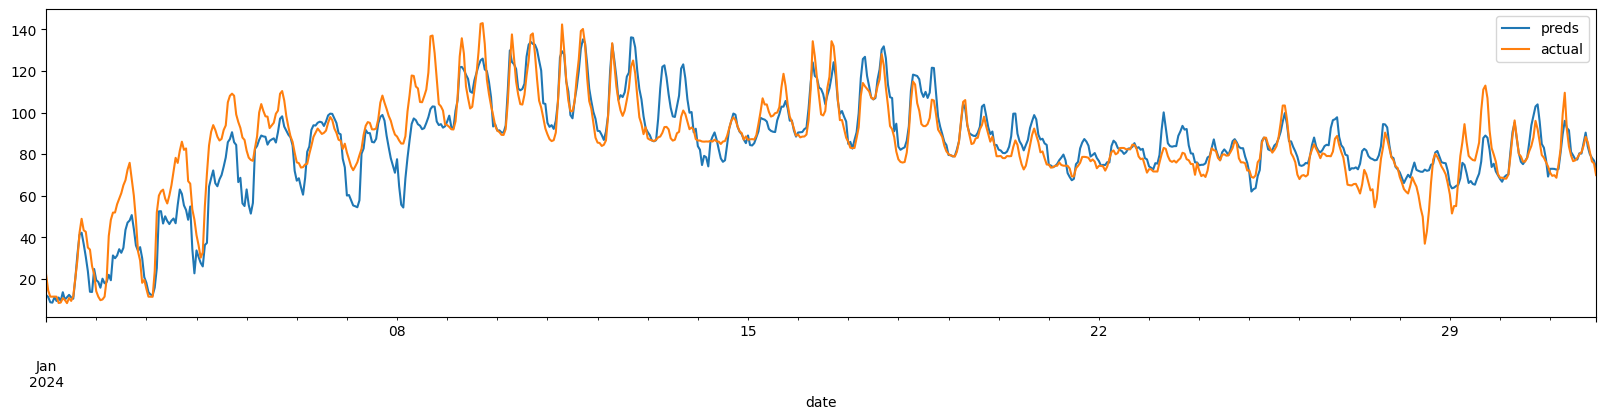

In [39]:
preds.plot(x="date", y=["preds", "actual"], figsize=(20, 4))

In [40]:
baseline = (
    df.assign(baseline=lambda x: x.day_ahead_price_ch.shift(24))
    .query("date.dt.date in @test_days")
    .filter(["date", "day_ahead_price_ch", "baseline"])
    .rename(columns={"baseline": "preds", "day_ahead_price_ch": "actual"})
)

In [41]:
print("Metric for LGBM Model")
print("R2 Score: ", r2_score(preds["actual"], preds["preds"]))
print("MAE: ", mean_absolute_error(preds["actual"], preds["preds"]))
print("MAPE: ", mean_absolute_percentage_error(preds["actual"], preds["preds"]))
print("RMSE: ", root_mean_squared_error(preds["actual"], preds["preds"]))

Metric for LGBM Model
R2 Score:  0.7900013961115148
MAE:  7.745346380690404
MAPE:  0.10477786235913518
RMSE:  10.60972018362299


In [42]:
print("Metric for baseline model")
print("R2 Score: ", r2_score(baseline["actual"], baseline["preds"]))
print("MAE: ", mean_absolute_error(baseline["actual"], baseline["preds"]))
print("MAPE: ", mean_absolute_percentage_error(baseline["actual"], baseline["preds"]))
print("RMSE: ", root_mean_squared_error(baseline["actual"], baseline["preds"]))

Metric for baseline model
R2 Score:  0.693600766406421
MAE:  8.569030955585465
MAPE:  0.11511246599495328
RMSE:  12.815618294665404
